In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import spearmanr, norm


import sys

sys.path.append('../src')
from utils import getExperimentConfig

# Get global experiment settings
config = getExperimentConfig()
folders = config['folders']

model_performance_file = folders['model_perf_filepath']

pf_filepaths = [
    '../data/result/BNLogLikelihood.csv',
    '../data/result/Cluster_1.csv',
    '../data/result/ContinousKLD.csv',
    '../data/result/CrCl.csv',
    '../data/result/CSTest.csv',
    '../data/result/DiscreteKLD.csv',
    '../data/result/GMLogLikelihood.csv',
    '../data/result/KSComplement.csv',
    '../data/result/pMSE.csv',
]
pf_metrics = [
    'BNLogLikelihood',
    'Cluster_G_1',
    'ContinousKLDivergence',
    'CrCl',
    'CSTest',
    'DiscreteKLDivergence',
    'GMLogLikelihood',
    'KSComplement',
    'pMSE',
]
cat_pf_metrics = [
    'BNLogLikelihood',
    'CSTest',
    'DiscreteKLDivergence',
]

pf_metric_times = [f"{pf}_time" for pf in pf_metrics]

models = [
    'knn',
    'o_knn',
    'lr',
    'o_lr',
    'rf',
    'o_rf',
    'svm',
    'o_svm',
]
performance_metrics = [
                        'F1_macro',
                        'Accuracy',
                        'Precision_macro',
                        'Recall_macro',
                        'Precision_weighted',
                        'Recall_weighted',
                        'F1_weighted',
                        'MCC',
                        'Kappa'
                    ]
original_performance_metrics = {f"{col}" : f"original_{col}" for col in performance_metrics}

datasetnames = {
    'D405': 'Adult',
    'D205': 'Bank',
    'D0' : 'Diabetes',
    'D305': 'MNIST',
    'D1': 'Titanic',
}
cat_o_ids = ['Adult', 'Bank', 'Titanic']

figures_fp = '../data/result/figures/'


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
sns.set_palette('colorblind')

In [51]:
fig_pf_epochs_dpi = 300
fig_pf_perf_dpi = 300
fig_large_dpi = 400

fig_pf_epochs_size = (6,4)
fig_large_pf_epochs_size = (12,4)

fig_pf_epochs_title_size  = 0
fig_pf_e_axel_label_size = 14


Noted that the performances deviates from normal distributions which will be taken into account when choosing the statistical test. Meaning, we cannot choose a test that requires the data
to be normally distributed.

# Data preperation
Organize the results into a single dataframe.

In [3]:
def extract_dataset_id(sdg):
    # used to extract the original dataset id from the SDG column
    match = re.match(r'SD(\d+)Q\d+', sdg)
    if match:
        return f'D{match.group(1)}'
    else:
        return None
    
def extract_epochs(quality):
    # used to extract the number of epochs as integers from the Quality column
    match = re.match(r'Q(\d+)', quality)
    if match:
        try:
            return int(f'{match.group(1)}')
        except ValueError:
            print(f"Cannot parse '{match.group(1)}' into an integer.")
            return None
    else:
        return None

##### Population fidelity measures #####
# read all population fidelity data into a single dataframe
pf_df_list = []
for fp in pf_filepaths:
    pf_df_list.append(pd.read_csv(fp))
        
pf_df = pd.concat(pf_df_list, axis=1,)
pf_df = pf_df.loc[:, ~pf_df.columns.duplicated()]
# rename column to match model performance dataframe
pf_df = pf_df.rename(columns={"Original dataset":"Original id"})

##### Model performance #####
models_df = pd.read_csv(model_performance_file)

#select the samples with original model performance
o_model_df = models_df[models_df['Quality'].isna() & models_df['SDG'].isna()].copy()
o_model_df = o_model_df.drop(columns=['Quality', 'SDG'])

df = o_model_df.copy()
df = df.groupby(['model'])['F1_macro'].mean().sort_values(ascending=False)
display(f"Mean original model performance: ")
display(df)

best_f1_original_model = df[0]

#select the samples with synthetic model performance
s_model_df = models_df[models_df['sklearn-report'].isna() & models_df['val_score'].isna()]
perf_df = s_model_df.drop(columns=['sklearn-report','val_score', 'Params'])

# add column with the original dataset
perf_df['Original id'] = perf_df['SDG'].apply(extract_dataset_id)
# add column epochs of the SDG
perf_df['Epochs'] = perf_df['Quality'].apply(extract_epochs)

for col in performance_metrics:
    perf_df[f"original_{col}"] = np.nan

# For each original model performance
for index, row in o_model_df.iterrows():
    d_id = row['Dataset id']
    model = row['model']

    # Locate the rows in synthetic dataset that match original dataset id and model
    mask = (perf_df['Original id'] == d_id) & (perf_df['model'] == model)

    # Update the performance metrics for the located rows and compute difference and ratio of performance
    for col in performance_metrics:
        perf_df.loc[mask, f"original_{col}"] = row[col]
        # synthetic performance / original performance
        perf_df[f'{col}_ratio'] =  perf_df[col] / perf_df[f'original_{col}']

    perf_df[f'F1_macro_overall_ratio'] = perf_df['F1_macro'] / best_f1_original_model

perf_df['model'] = perf_df['model'].replace('rbfsvm', 'svm')
# add the prefix 'o_' to the models that are trained and tuned on the original data e.g. 'rf' -> 'o_rf'
perf_df.loc[perf_df['Tuned on'] == 'original', 'model'] = 'o_' + perf_df.loc[perf_df['Tuned on'] == 'original', 'model']

perf_df.reset_index(inplace=True, drop=True)
# combine model performance with population fidelity measures into a single dataframe
result = pd.merge(right=perf_df, left=pf_df, on=['Dataset id', 'Quality','SDG','Original id'])

# Replace Ids with more meaningful dataset names
result['Original id'] = result['Original id'].map(datasetnames)

display(result)

# Compute mean of all models trained on the datasets derived from the same SDG
mean_columns = list()
mean_columns.extend(performance_metrics)
mean_columns.extend([f"{pf}_ratio" for pf in performance_metrics])
mean_columns.append('F1_macro_overall_ratio')
mean_columns.extend(pf_metrics)
mean_columns.extend(pf_metric_times)
grouped_result = result.groupby(['SDG', 'model', 'Trained on', 'Tuned on', 'Quality', 'Epochs', 'Original id'])[mean_columns].mean()
grouped_result = grouped_result.reset_index()
display(grouped_result)


'Mean original model performance: '

model
rf        0.813770
lr        0.776445
rbfsvm    0.762720
knn       0.734070
Name: F1_macro, dtype: float64

Dataset id        SDG  BNLogLikelihood  BNLogLikelihood_time Quality  \
0      SD0Q1000_0   SD0Q1000        -0.623251              0.274979   Q1000   
1      SD0Q1000_0   SD0Q1000        -0.623251              0.274979   Q1000   
2      SD0Q1000_0   SD0Q1000        -0.623251              0.274979   Q1000   
3      SD0Q1000_0   SD0Q1000        -0.623251              0.274979   Q1000   
4      SD0Q1000_0   SD0Q1000        -0.623251              0.274979   Q1000   
...           ...        ...              ...                   ...     ...   
1995  SD405Q500_9  SD405Q500       -15.813216              0.383187    Q500   
1996  SD405Q500_9  SD405Q500       -15.813216              0.383187    Q500   
1997  SD405Q500_9  SD405Q500       -15.813216              0.383187    Q500   
1998  SD405Q500_9  SD405Q500       -15.813216              0.383187    Q500   
1999  SD405Q500_9  SD405Q500       -15.813216              0.383187    Q500   

     Original id  Cluster_G_1  Cluster_G_1_time  ContinousKLDivergence  \
0       Diabetes     2.778006         99.090585               0.575750   
1       Diabetes     2.778006         99.090585               0.575750   
2       Diabetes     2.778006         99.090585               0.575750   
3       Diabetes     2.778006         99.090585               0.575750   
4       Diabetes     2.778006         99.090585               0.575750   
...          ...          ...               ...                    ...   
1995       Adult     1.730032        284.106545               0.816786   
1996       Adult     1.730032        284.106545               0.816786   
1997       Adult     1.730032        284.106545               0.816786   
1998       Adult     1.730032        284.106545               0.816786   
1999       Adult     1.730032        284.106545               0.816786   

      ContinousKLDivergence_time      CrCl  CrCl_time    CSTest  CSTest_time  \
0                       0.096731  0.515663   0.104933  0.936856     0.003258   
1                       0.096731  0.515663   0.104933  0.936856     0.003258   
2                       0.096731  0.515663   0.104933  0.936856     0.003258   
3                       0.096731  0.515663   0.104933  0.936856     0.003258   
4                       0.096731  0.515663   0.104933  0.936856     0.003258   
...                          ...       ...        ...       ...          ...   
1995                    0.043590  0.096805   8.143610  0.876998     0.005551   
1996                    0.043590  0.096805   8.143610  0.876998     0.005551   
1997                    0.043590  0.096805   8.143610  0.876998     0.005551   
1998                    0.043590  0.096805   8.143610  0.876998     0.005551   
1999                    0.043590  0.096805   8.143610  0.876998     0.005551   

      DiscreteKLDivergence  DiscreteKLDivergence_time  GMLogLikelihood  \
0                      NaN                   0.002195    -2.874710e+01   
1                      NaN                   0.002195    -2.874710e+01   
2                      NaN                   0.002195    -2.874710e+01   
3                      NaN                   0.002195    -2.874710e+01   
4                      NaN                   0.002195    -2.874710e+01   
...                    ...                        ...              ...   
1995              0.689417                   0.131052    -1.920049e+10   
1996              0.689417                   0.131052    -1.920049e+10   
1997              0.689417                   0.131052    -1.920049e+10   
1998              0.689417                   0.131052    -1.920049e+10   
1999              0.689417                   0.131052    -1.920049e+10   

      GMLogLikelihood_time  KSComplement  KSComplement_time      pMSE  \
0                 1.379944      0.876302           0.005992  0.592673   
1                 1.379944      0.876302           0.005992  0.592673   
2                 1.379944      0.876302           0.005992  0.592673   
3                 1.379944 

SDG  model Trained on   Tuned on Quality  Epochs Original id  \
0       SD0Q10    knn  synthetic  synthetic     Q10      10    Diabetes   
1       SD0Q10     lr  synthetic  synthetic     Q10      10    Diabetes   
2       SD0Q10  o_knn  synthetic   original     Q10      10    Diabetes   
3       SD0Q10   o_lr  synthetic   original     Q10      10    Diabetes   
4       SD0Q10   o_rf  synthetic   original     Q10      10    Diabetes   
..         ...    ...        ...        ...     ...     ...         ...   
195  SD405Q500   o_lr  synthetic   original    Q500     500       Adult   
196  SD405Q500   o_rf  synthetic   original    Q500     500       Adult   
197  SD405Q500  o_svm  synthetic   original    Q500     500       Adult   
198  SD405Q500     rf  synthetic  synthetic    Q500     500       Adult   
199  SD405Q500    svm  synthetic  synthetic    Q500     500       Adult   

     F1_macro  Accuracy  Precision_macro  Recall_macro  Precision_weighted  \
0    0.463494  0.505649         0.471830      0.471341            0.518391   
1    0.438417  0.602208         0.469664      0.494835            0.520239   
2    0.451894  0.495455         0.456417      0.455611            0.503432   
3    0.419797  0.533117         0.467699      0.447556            0.509312   
4    0.474423  0.525974         0.479154      0.477407            0.524974   
..        ...       ...              ...           ...                 ...   
195  0.430800  0.746799         0.404035      0.497240            0.579797   
196  0.431650  0.744371         0.466141      0.496227            0.610309   
197  0.435307  0.745475         0.463216      0.498159            0.609234   
198  0.429471  0.752759         0.376380      0.500000            0.566647   
199  0.429788  0.752406         0.396364      0.499915            0.576512   

     Recall_weighted  F1_weighted       MCC     Kappa  F1_macro_ratio  \
0           0.505649     0.504522 -0.056765 -0.055989        0.685181   
1           0.602208     0.523344  0.008752 -0.002608        0.620503   
2           0.495455     0.495510 -0.087809 -0.085333        0.668033   
3           0.533117     0.490546 -0.091948 -0.098378        0.594148   
4           0.525974     0.522042 -0.043591 -0.044008        0.712239   
..               ...          ...       ...       ...             ...   
195         0.746799     0.645186 -0.026344 -0.008128        0.544180   
196         0.744371     0.644757 -0.024462 -0.010959        0.447778   
197         0.745475     0.646863 -0.015621 -0.005386        0.582331   
198         0.752759     0.646577  0.000000  0.000000        0.445518   
199         0.752406     0.646608 -0.000909 -0.000252        0.574947   

     Accuracy_ratio  Precision_macro_ratio  Recall_macro_ratio  \
0          0.701532               0.681509            0.703494   
1          0.806435               0.648174            0.708407   
2          0.687387               0.659246            0.680017   
3          0.713913               0.645462            0.640721   
4          0.750000               0.715360            0.719509   
..              ...                    ...                 ...   
195        0.876425               0.499799            0.638436   
196        0.764626               0.480613            0.517755   
197        0.910243               0.610759            0.674228   
198        0.773243               0.388065            0.521692   
199        0.918706               0.522613            0.676605   

     Precision_weighted_ratio  Recall_weighted_ratio  F1_weighted_ratio  \
0                    0.728511               0.701532           0.708374   
1                    0.703420               0.806435           0.708183   
2                    0.707489               0.687387           0.695720   
3                    0.688646               0.713913           0.663802   
4                    0.753587               0.750000           0.747394   
..                        ...                    ... 

<AxesSubplot: xlabel='F1_macro_overall_ratio', ylabel='Density'>

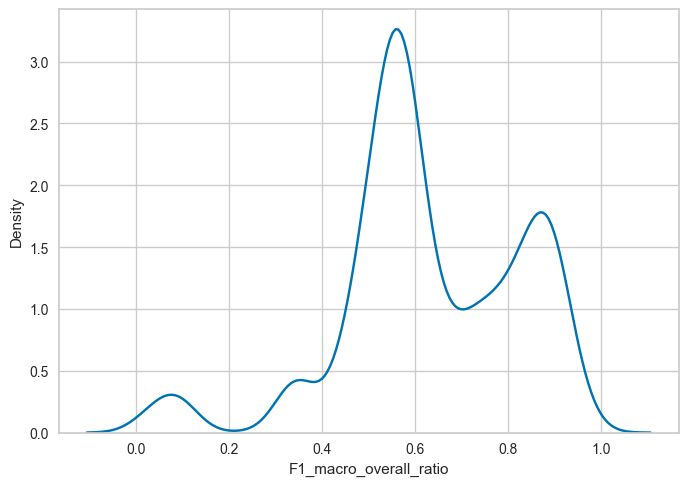

In [4]:
sns.kdeplot(data=result, x='F1_macro_overall_ratio')

'Diabetes'

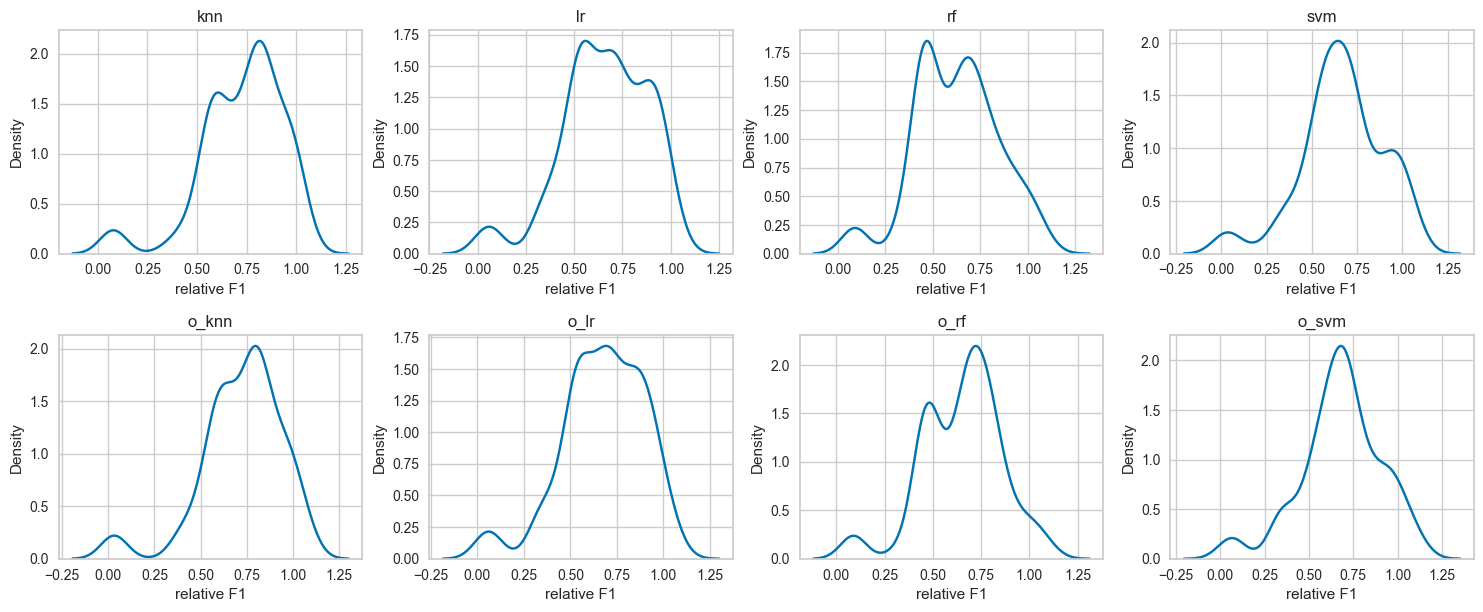

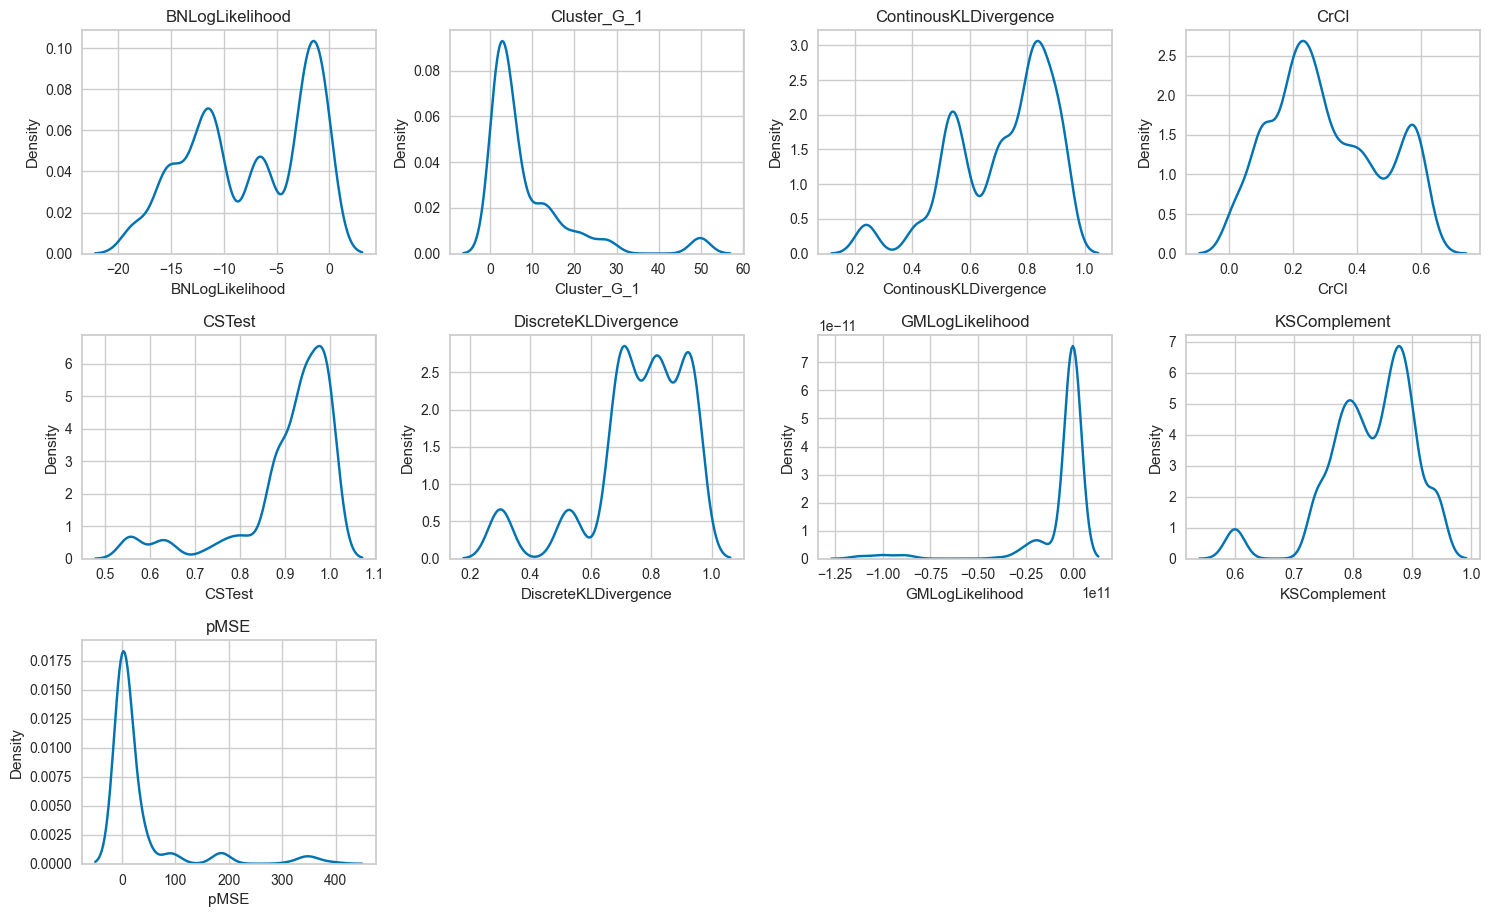

'Titanic'

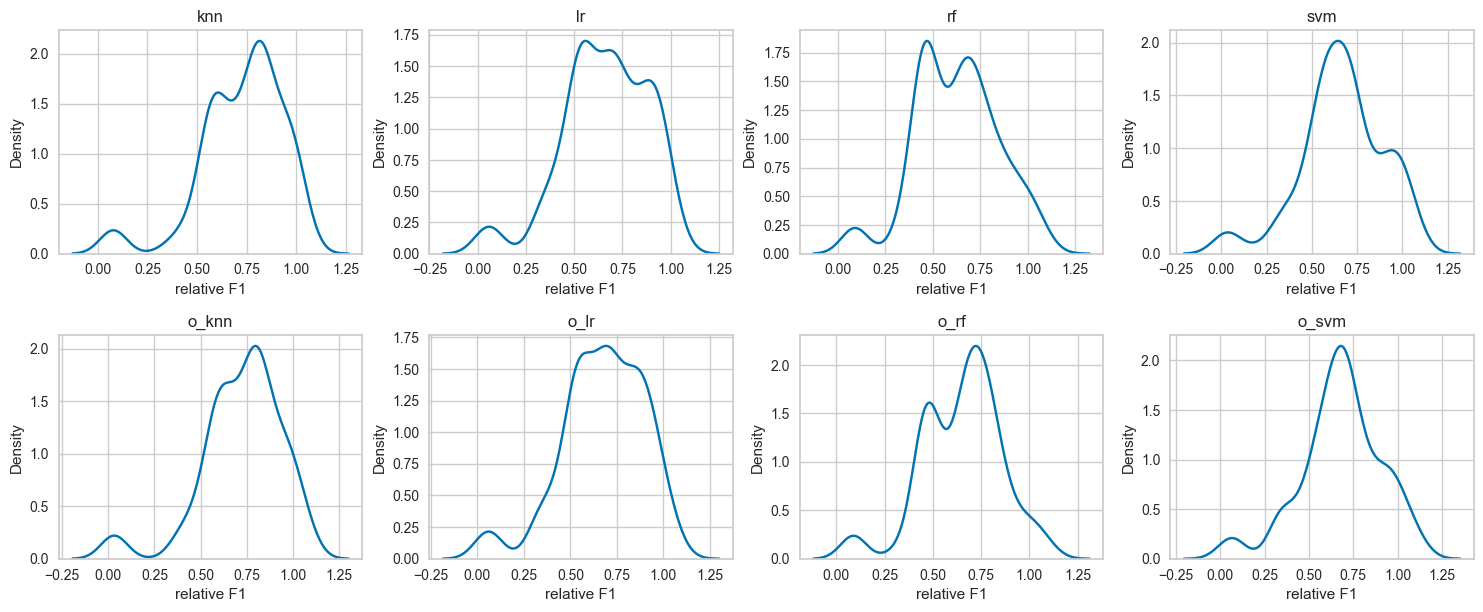

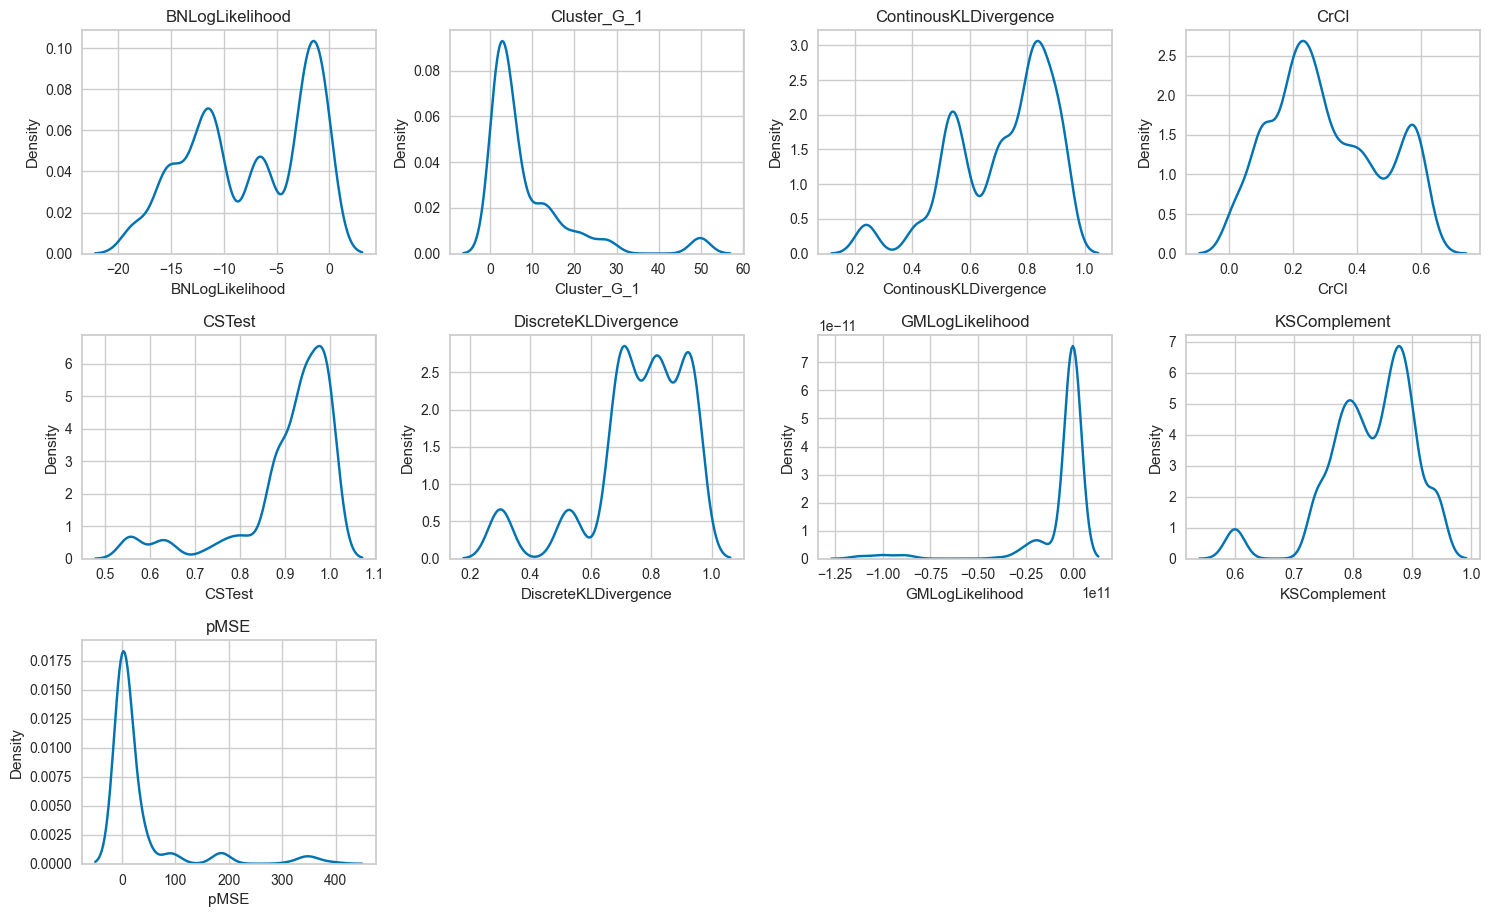

'Bank'

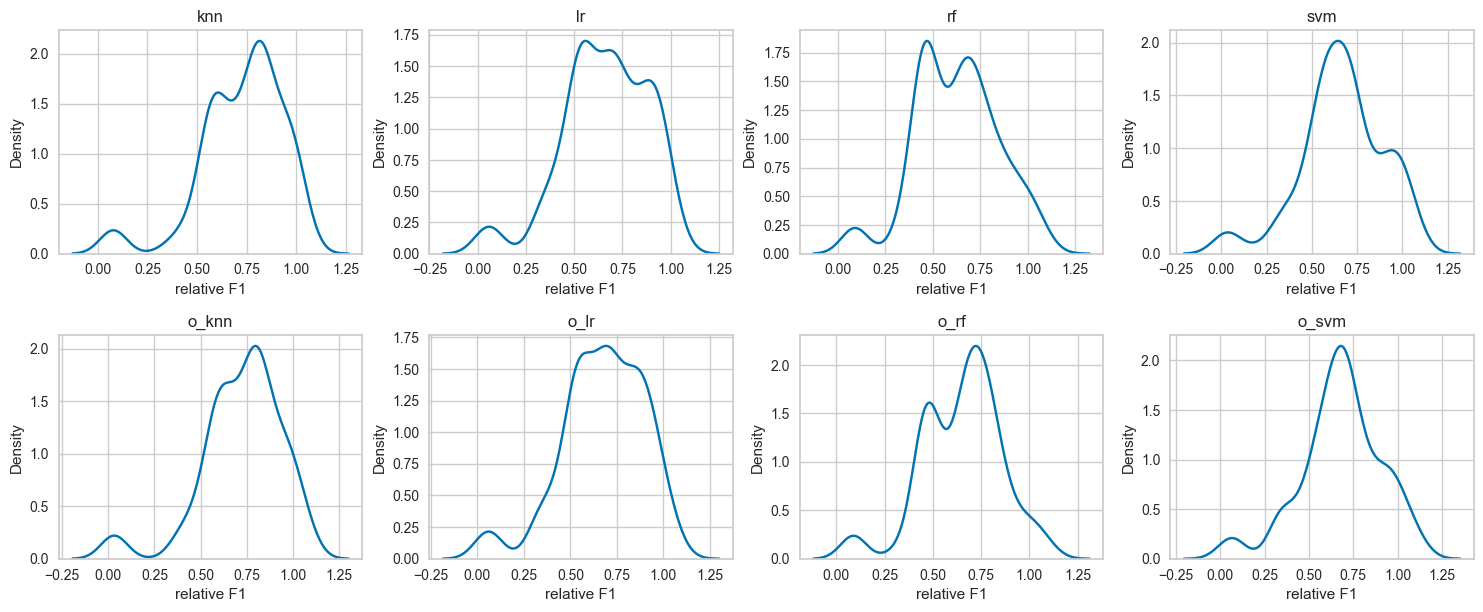

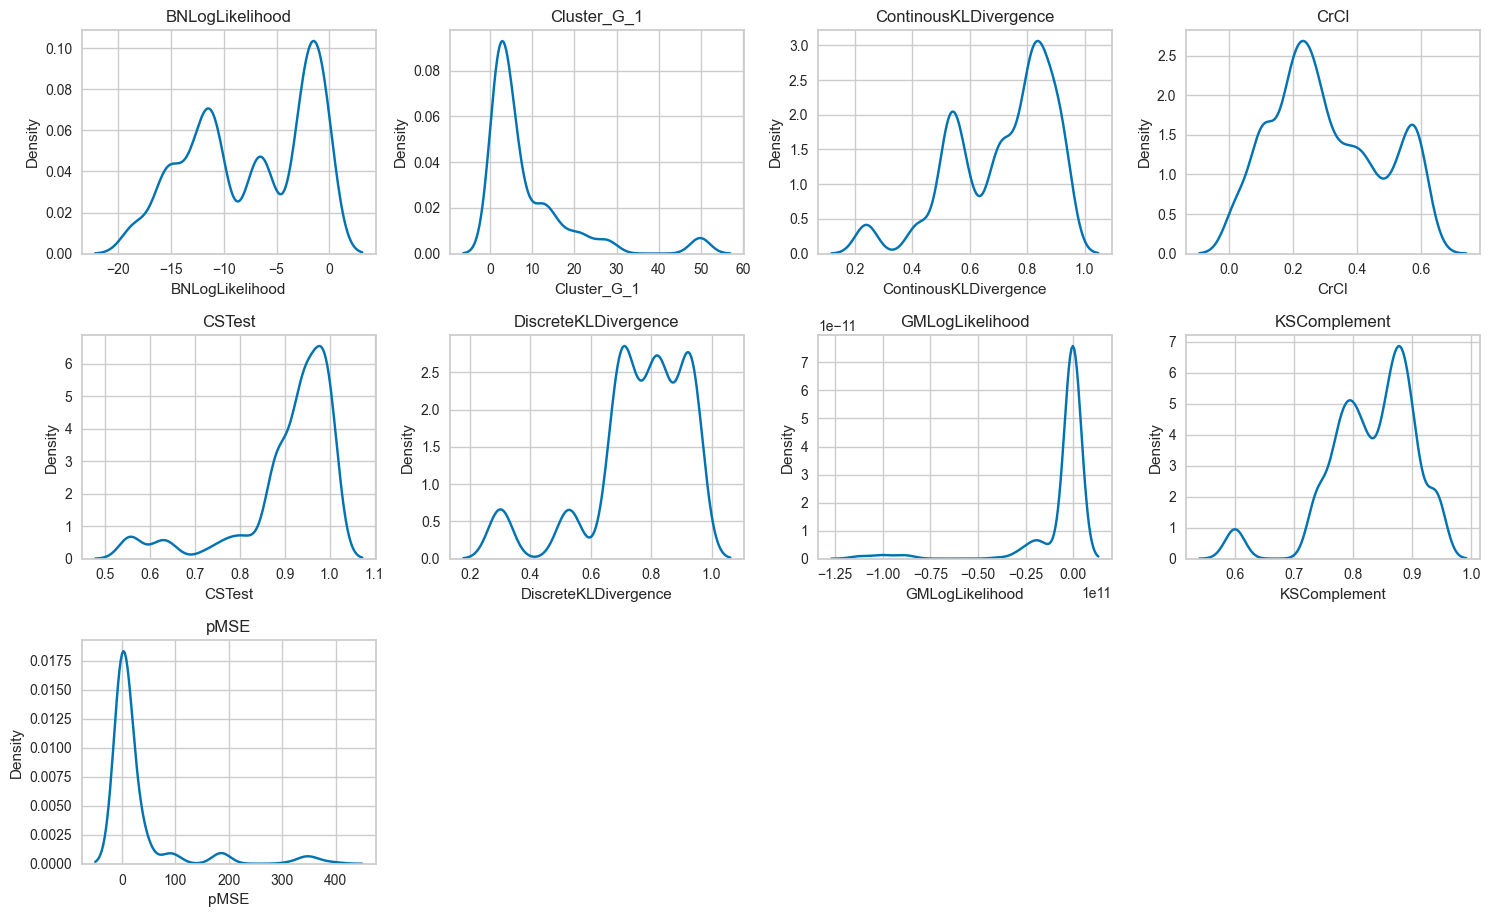

'MNIST'

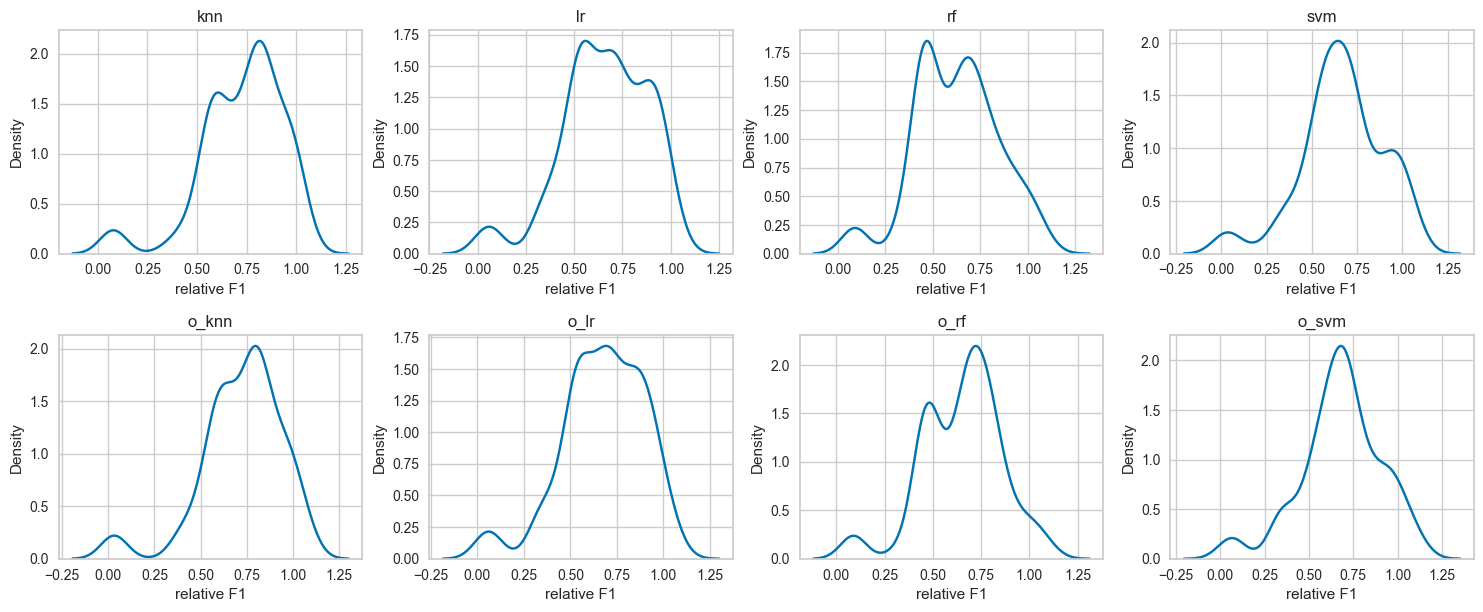

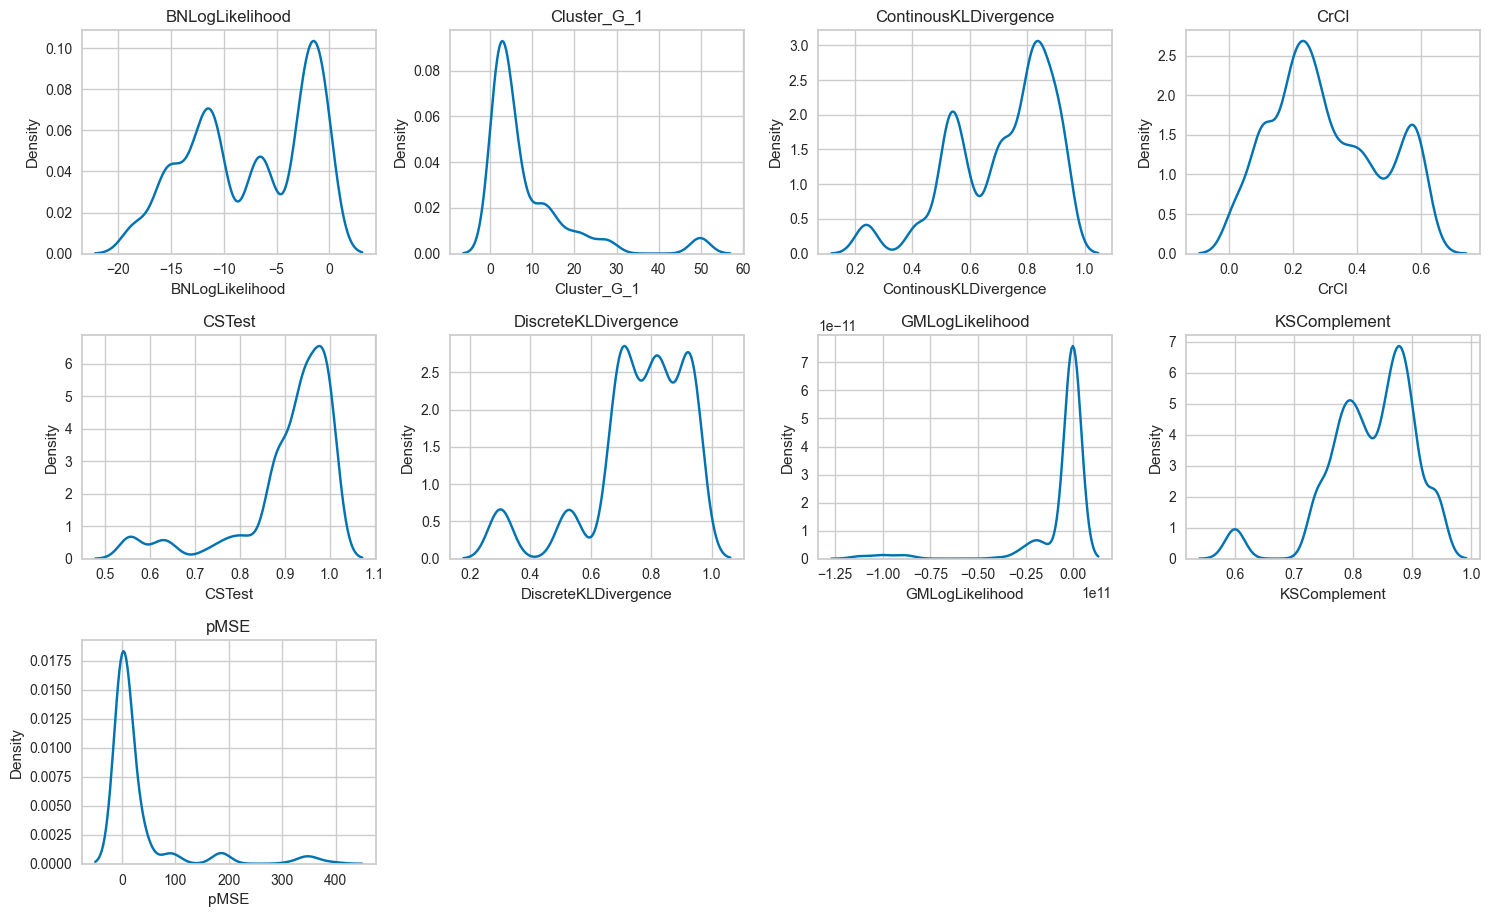

'Adult'

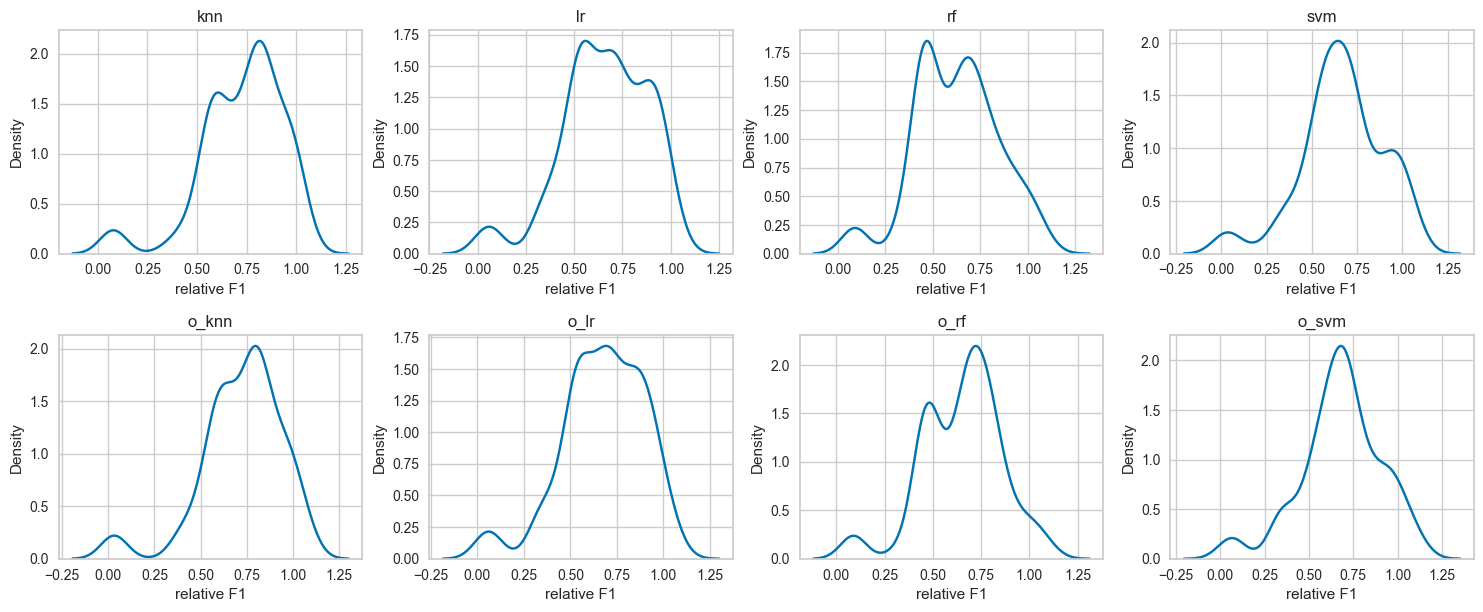

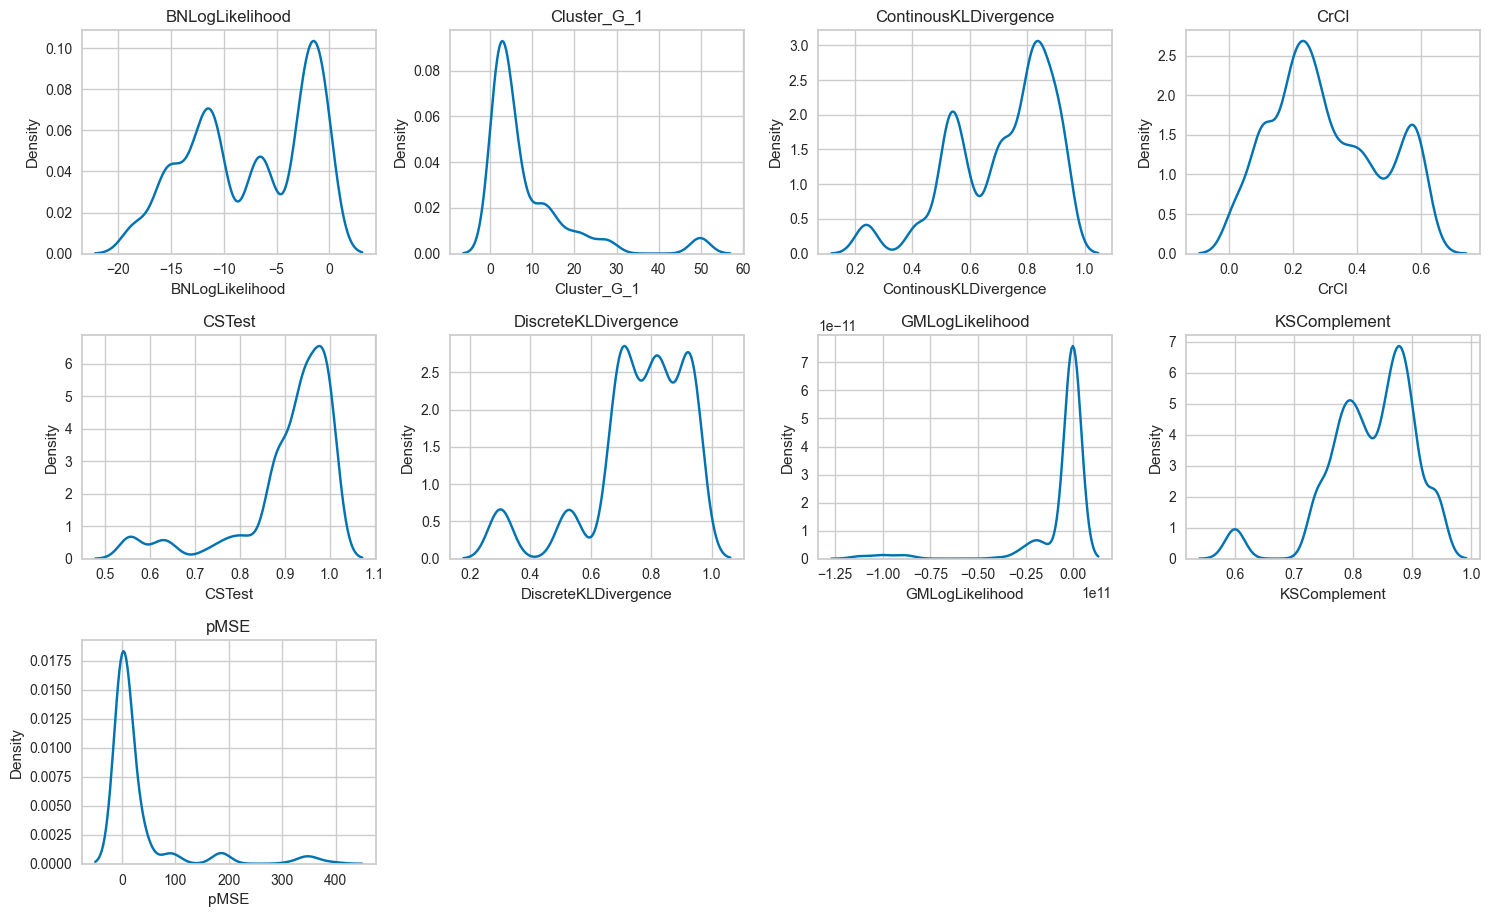

In [5]:
model_list = [
    'knn',
    'lr',
    'rf',
    'svm',
    'o_knn',
    'o_lr',
    'o_rf',
    'o_svm',
]

for d_id in result['Original id'].unique():
    display(d_id)

    fig, axes = plt.subplots(5,4, figsize=(15,15))
    axes = axes.flatten()

    for i, model in enumerate(model_list):
        mask = (result['model']==model)
        data = result.loc[mask]
        sns.kdeplot(data=data, x='F1_macro_ratio', ax=axes[i])
        axes[i].set_title(f"{model}")
        axes[i].set_xlabel('relative F1')

    for j in range(i+1, 20):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(5,4, figsize=(15,15))

    axes = axes.flatten()

    for i, pf in enumerate(pf_metrics):
        sns.kdeplot(data=result, x=pf, ax=axes[i])
        axes[i].set_title(f"{pf}")

    for j in range(i+1, 20):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Model performance related to epochs

## mean Model performance of all models vs Epochs

This shows how well the epochs correlate with the actual model performance.

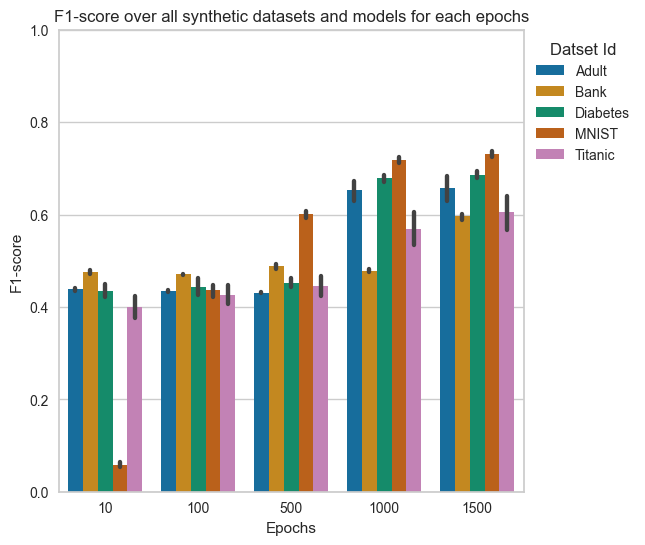

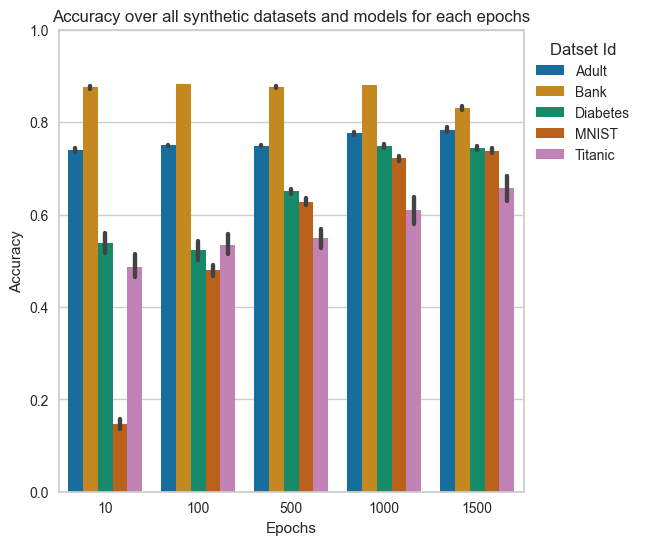

In [6]:
x_axis = 'Epochs'
unique_original_datasets = result['Original id'].unique()

### Epochs vs F1 macro
y_axis="F1_macro"
# Get unique original datasets

plt.figure(figsize=(6,6))

sns.barplot(
    x=x_axis,
    y=y_axis,
    data=result,
    hue='Original id',
    hue_order=list(datasetnames.values())
)

# Define y-axis limits
plt.ylim(0, 1)

# Add labels and title
plt.xlabel(x_axis)
plt.ylabel('F1-score')
plt.title("F1-score over all synthetic datasets and models for each epochs")

# Add legend
plt.legend(title='Datset Id', bbox_to_anchor=(1.0, 1), loc='upper left')

plt.savefig(f"{figures_fp}f1_vs_epochs_all.png", bbox_inches='tight', dpi=500)
# Display the plot
plt.show()

### Epochs vs accuracy
y_axis='Accuracy'
# Get unique original datasets
unique_original_datasets = result['Original id'].unique()

plt.figure(figsize=(6,6))

sns.barplot(
    x=x_axis,
    y=y_axis,
    data=result,
    hue='Original id',
    hue_order=list(datasetnames.values())
)

# Define y-axis limits
plt.ylim(0, 1)

# Add labels and title
plt.xlabel(x_axis)
plt.ylabel('Accuracy')
plt.title("Accuracy over all synthetic datasets and models for each epochs")

# Add legend
plt.legend(title='Datset Id', bbox_to_anchor=(1.0, 1), loc='upper left')

plt.savefig(f"{figures_fp}accuracy_vs_epochs_all.png", bbox_inches='tight', dpi=500)
# Display the plot
plt.show()


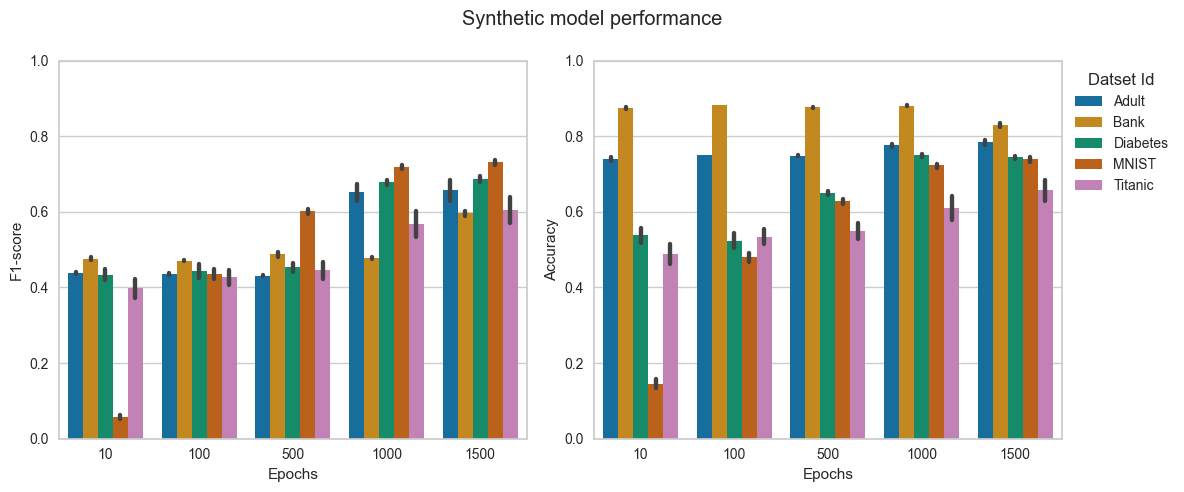

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

x_axis = 'Epochs'
unique_original_datasets = result['Original id'].unique()

# Create a figure and a grid of subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig.suptitle("Synthetic model performance")

# --------------------- Plot for F1 macro ---------------------
y_axis="F1_macro"

sns.barplot(
    x=x_axis,
    y=y_axis,
    data=result,
    hue='Original id',
    hue_order=list(datasetnames.values()),
    ax=ax[0]
)

# Define y-axis limits
ax[0].set_ylim(0, 1)

# Add labels and title
ax[0].set_xlabel(x_axis)
ax[0].set_ylabel('F1-score')
ax[0].legend().remove()

# --------------------- Plot for Accuracy ---------------------
y_axis='Accuracy'

sns.barplot(
    x=x_axis,
    y=y_axis,
    data=result,
    hue='Original id',
    hue_order=list(datasetnames.values()),
    ax=ax[1]
)

# Define y-axis limits
ax[1].set_ylim(0, 1)

# Add labels and title
ax[1].set_xlabel(x_axis)
ax[1].set_ylabel('Accuracy')

# Add legend
ax[1].legend(title='Datset Id', bbox_to_anchor=(1.0, 1), loc='upper left')

# Adjust the layout
plt.tight_layout()

# Save the combined figure
plt.savefig(f"{figures_fp}combined_metric_vs_epochs_all.png", bbox_inches='tight', dpi=500)

# Display the combined plots
plt.show()


## Difference in performance for each Dataset

The difference meaning (metric_diff): *Original performance metric - Synthetic performance metric*  
The ratio meaning (metric_ratio): $\frac{\text{Synthetic performance metric}}{\text{Original performance metric}}$
  
**model names**:  
  - lr: Logistic Regression
  - knn: K-Nearest Neighbor
  - svm: Support Vector Machines
  - rf: Random Forest
  - o_XXX: means the hyperparameters for the model was gained by tuning on the original data and the model was trained on synthetic data

## Performance_ratio, for the model with best average over all datasets for each performance metric

## Rerformance: F1_ratio

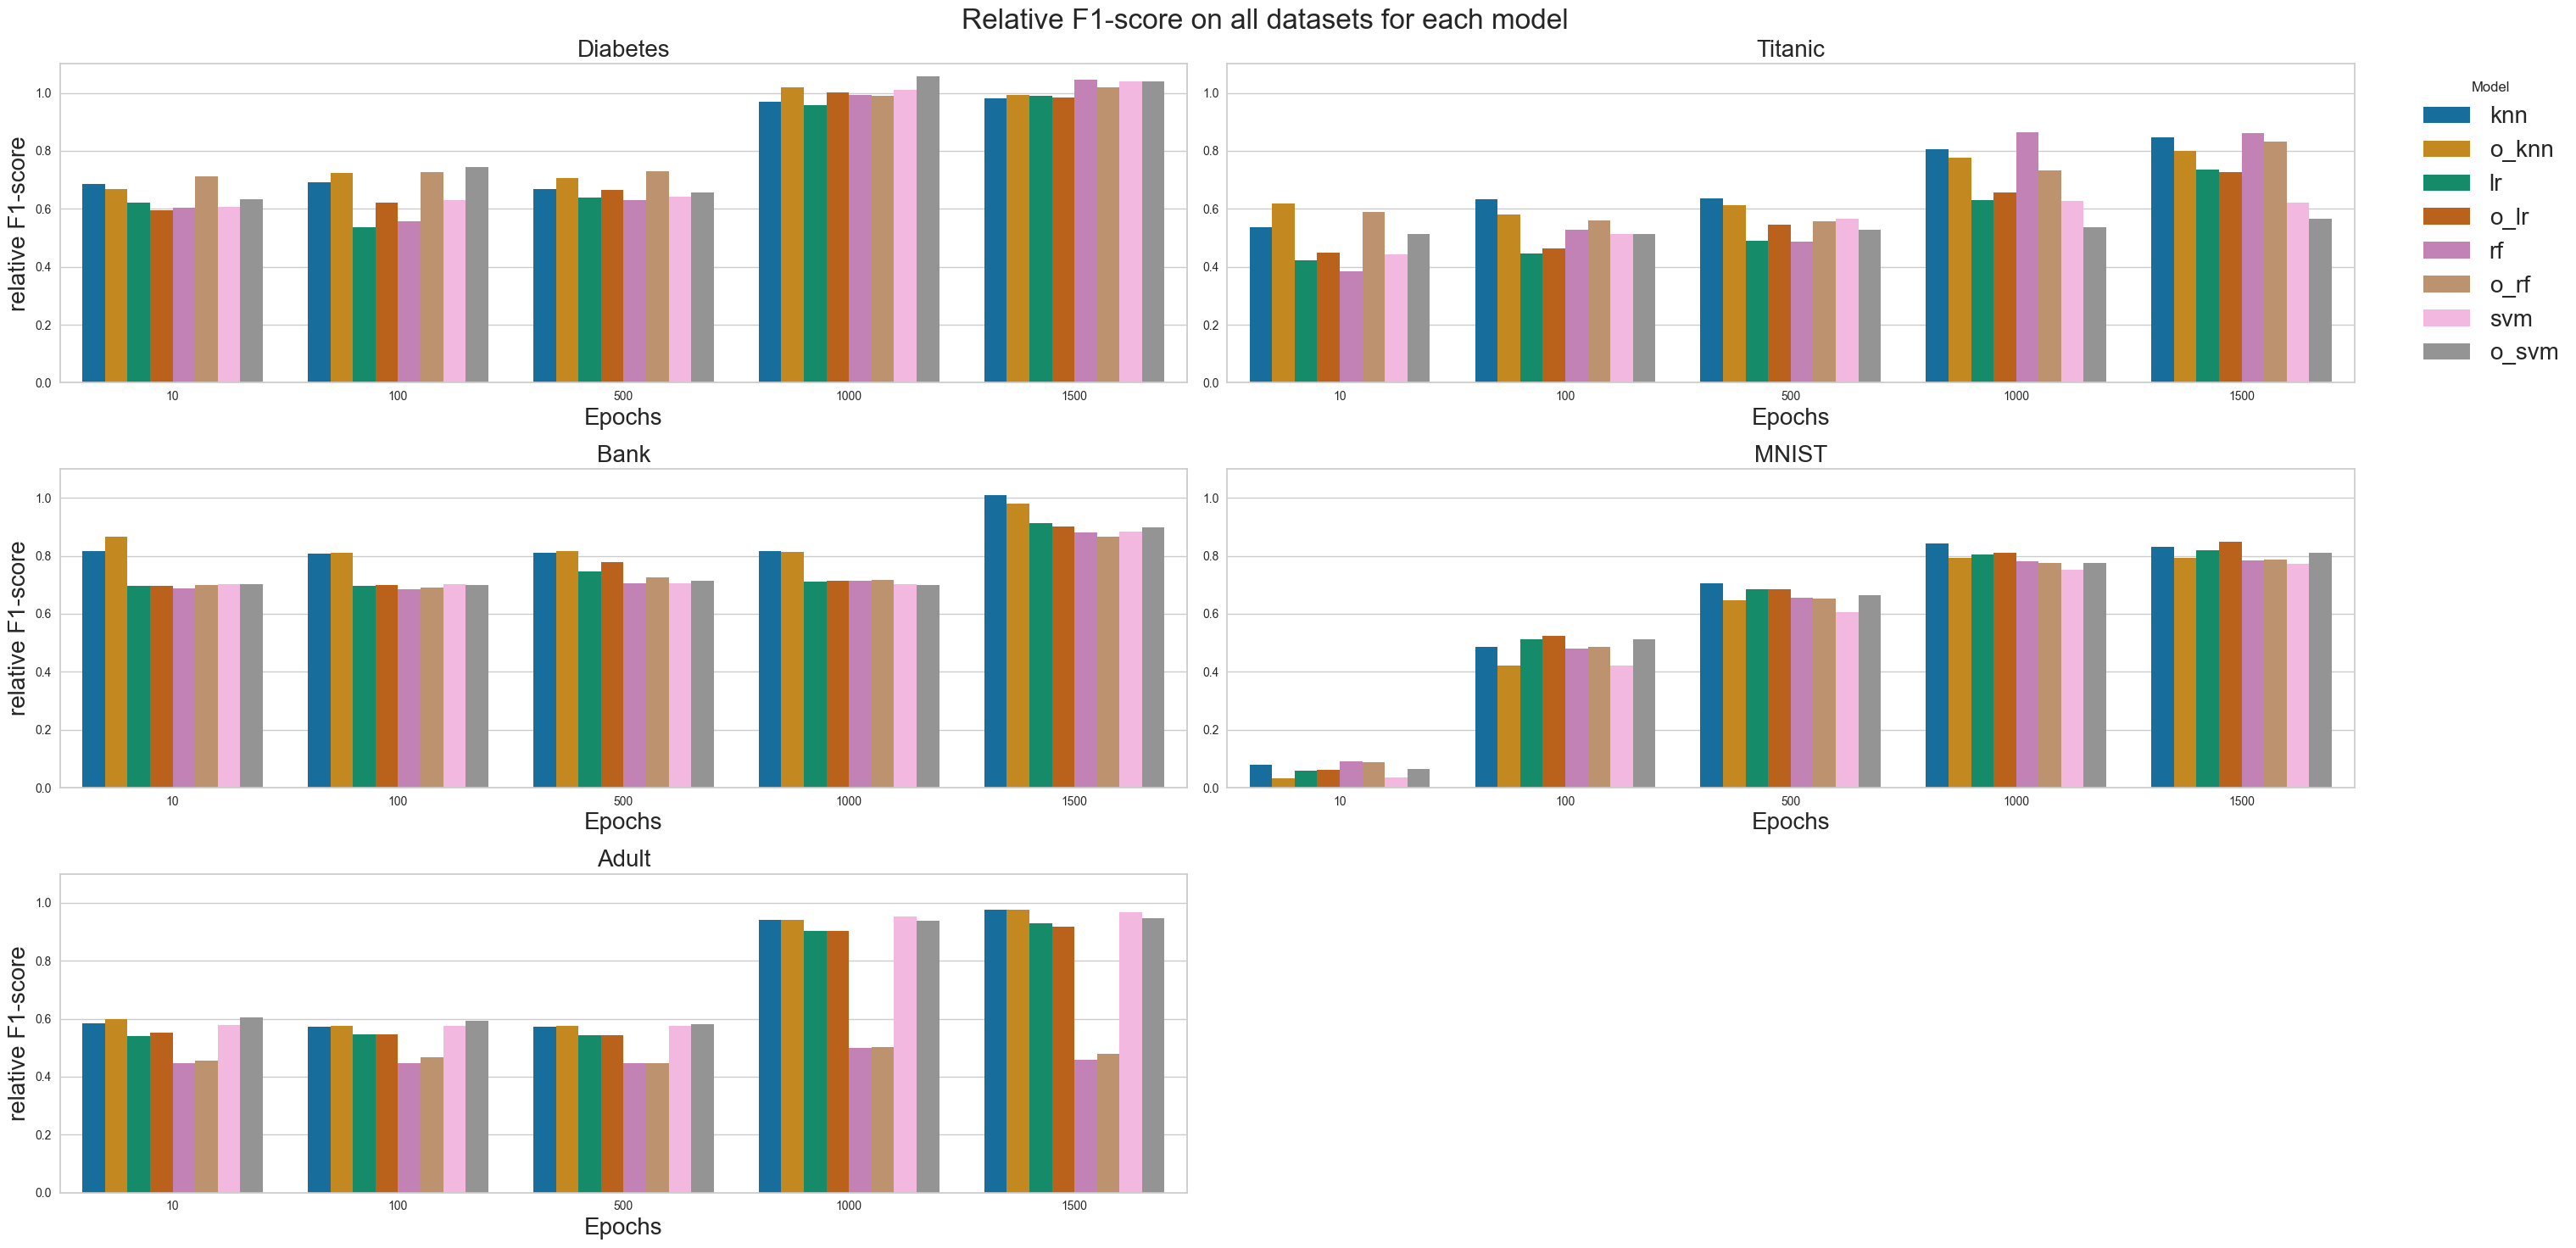

In [8]:
dataset_ids = grouped_result['Original id'].unique()
col_metric = 'F1_macro_ratio'
x_axis = 'Epochs'
# Create a grid of subplots based on the number of dataset_ids
fig, axes = plt.subplots(3, 2, figsize=(30,15) )
axes = axes.flatten()
ax_pos = 0

fig.suptitle("Relative F1-score on all datasets for each model", fontsize=24)
# Iterate over each dataset and each subplot axis
for ax, data_id in zip(axes, dataset_ids):
    filtered_data = grouped_result[grouped_result['Original id'] == data_id]
    
    sns.barplot(x=x_axis, y=col_metric, hue='model', hue_order=models, data=filtered_data, ax=ax)
    
    ax.set_ylim(0,1.1)
    ax.set_title(f"{data_id}", fontsize=20)
    ax.set_xlabel(x_axis, fontsize=20)

    if ax_pos % 2 == 0:
        ax.set_ylabel("relative F1-score", fontsize=20)
    else:
        ax.set_ylabel("")

    ax.set_xlabel(x_axis)
    if ax_pos == 1:
        ax.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), title="Model", fontsize=20)
    else:
        ax.get_legend().remove()
    ax_pos += 1

# If there's an extra subplot (empty), remove it
if len(dataset_ids) < len(axes):
    fig.delaxes(axes[-1])
# Adjust layout
plt.tight_layout()
plt.savefig(f"{figures_fp}f1_vs_epochs_all_datasets_all_models.png", bbox_inches='tight', dpi=500)
plt.show()


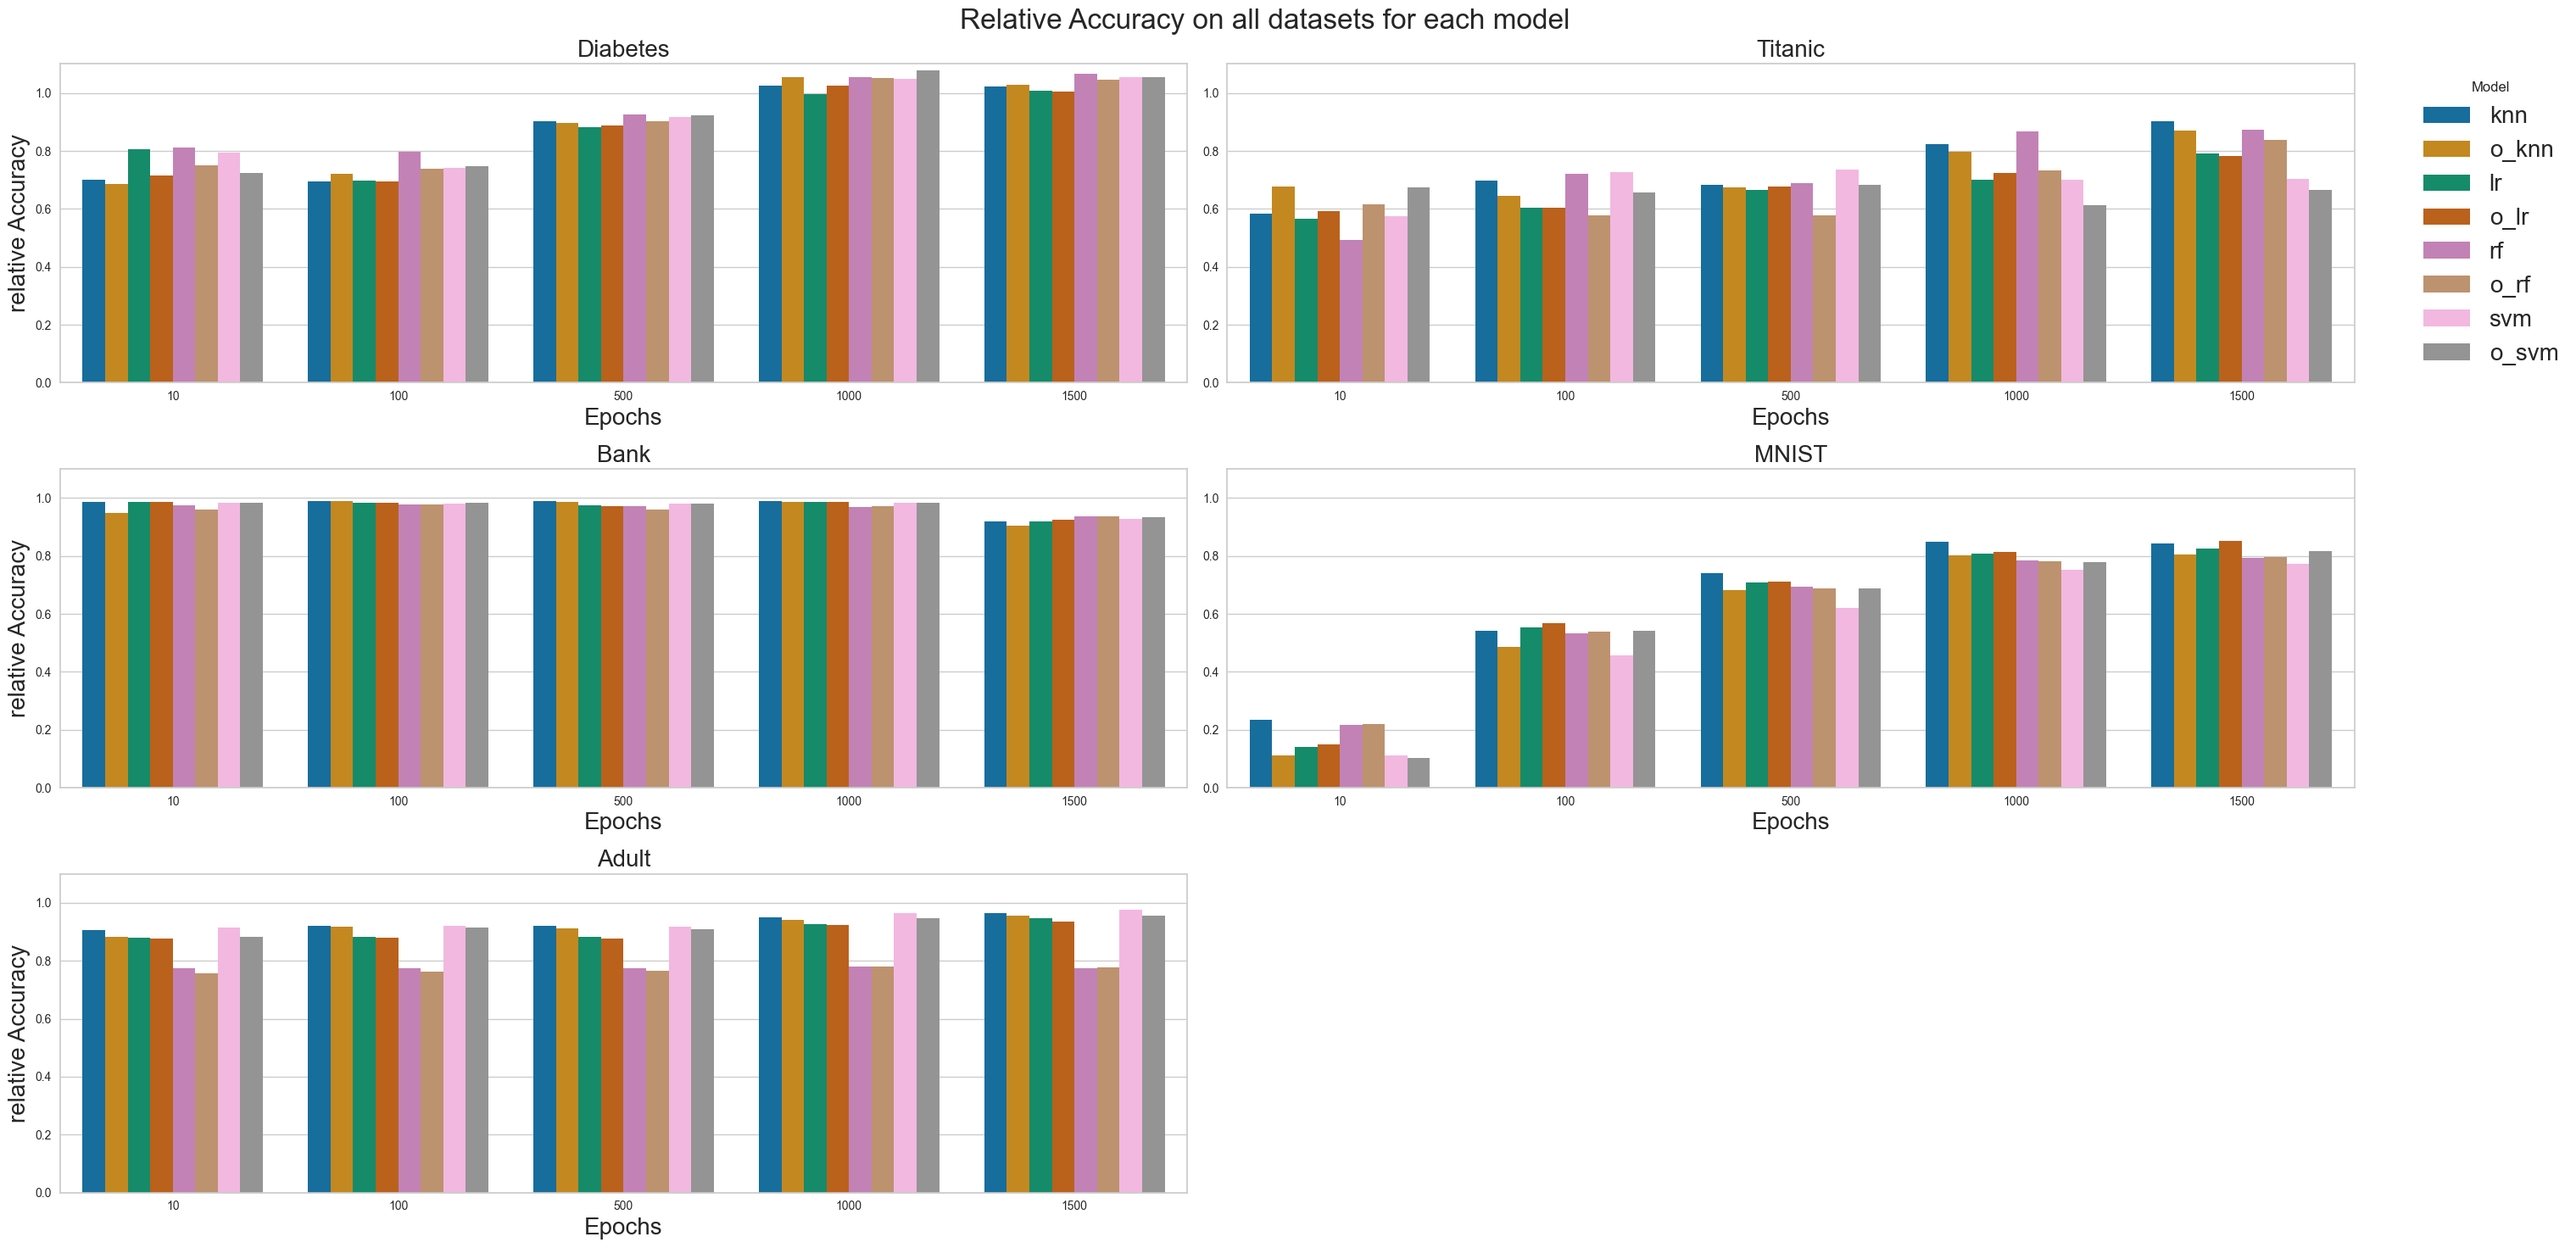

In [9]:
dataset_ids = grouped_result['Original id'].unique()
col_metric = 'Accuracy_ratio'
x_axis = 'Epochs'
# Create a grid of subplots based on the number of dataset_ids
fig, axes = plt.subplots(3, 2, figsize=(30,15) )
axes = axes.flatten()
ax_pos = 0

fig.suptitle("Relative Accuracy on all datasets for each model", fontsize=24)
# Iterate over each dataset and each subplot axis
for ax, data_id in zip(axes, dataset_ids):
    filtered_data = grouped_result[grouped_result['Original id'] == data_id]
    
    sns.barplot(x=x_axis, y=col_metric, hue='model', hue_order=models, data=filtered_data, ax=ax)
    
    ax.set_ylim(0,1.1)
    ax.set_title(f"{data_id}", fontsize=20)
    ax.set_xlabel(x_axis, fontsize=20)

    if ax_pos % 2 == 0:
        ax.set_ylabel("relative Accuracy", fontsize=20)
    else:
        ax.set_ylabel("")

    ax.set_xlabel(x_axis)
    if ax_pos == 1:
        ax.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), title="Model", fontsize=20)
    else:
        ax.get_legend().remove()
    ax_pos += 1

# If there's an extra subplot (empty), remove it
if len(dataset_ids) < len(axes):
    fig.delaxes(axes[-1])
# Adjust layout
plt.tight_layout()
plt.savefig(f"{figures_fp}accuracy_vs_epochs_all_datasets_all_models.png", bbox_inches='tight', dpi=500)
plt.show()


# MNIST images

In [10]:
def show_mnist_img(images: pd.DataFrame, title: str):
    # Count the number of unique labels
    num_labels = images['label'].nunique()
    # Adjust the grid size based on the number of labels
    num_rows = num_labels // 5 + (num_labels % 5 > 0)
    fig, axes = plt.subplots(num_rows, 5, figsize=(10,2*num_rows))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    # Remove the unused subplots
    for ax in axes[num_labels:]:
        fig.delaxes(ax)
    for i in range(num_labels):
        label = images.iloc[i]['label']
        img = images.iloc[i][1:]
        pixels = np.array(img).reshape(28,28)
        axes[i].imshow(pixels, cmap='gray')
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_title(f"Label: {label}")
    plt.tight_layout()
    plt.savefig(f"{figures_fp}mnist {title}.png", bbox_inches='tight', dpi=500)
    plt.show()


Original data


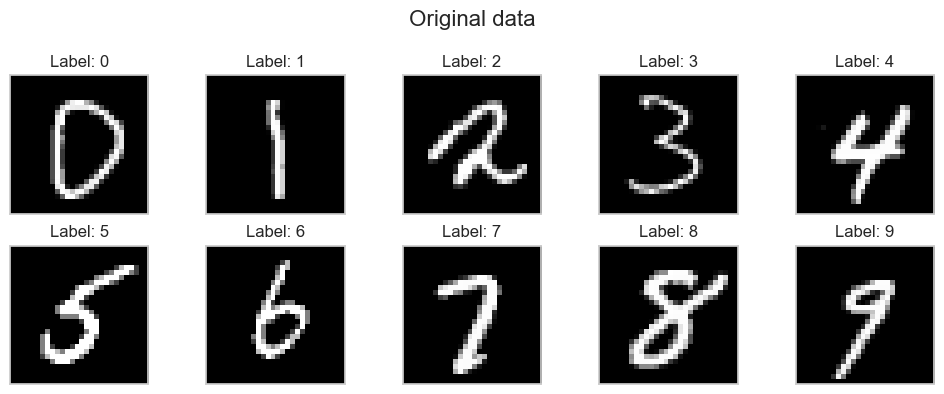

Epochs 10


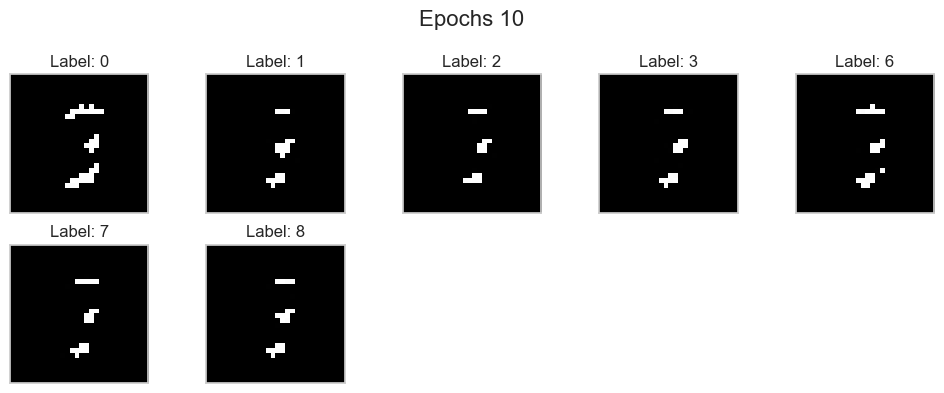

Epochs 100


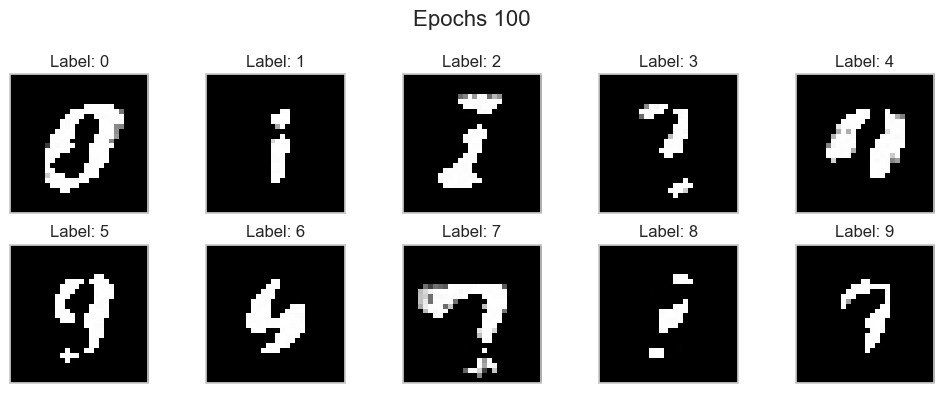

Epochs 500


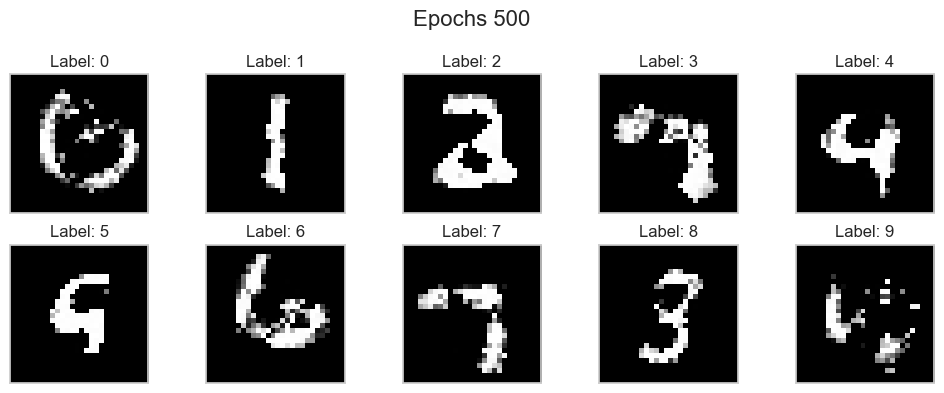

Epochs 1000


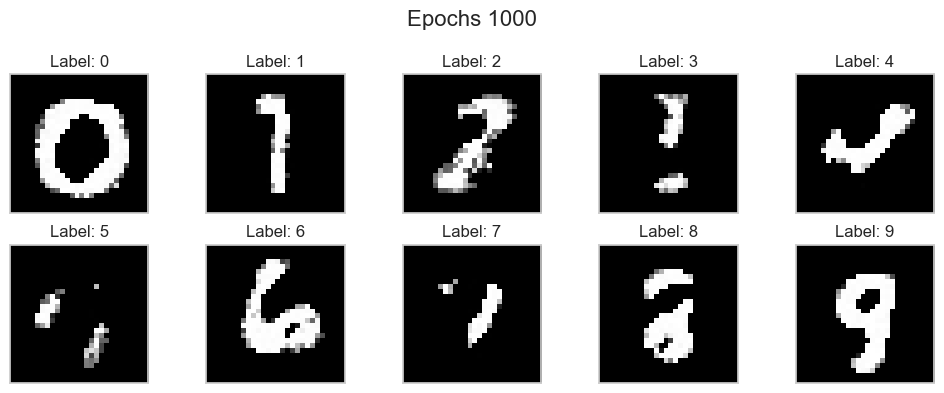

Epochs 1500


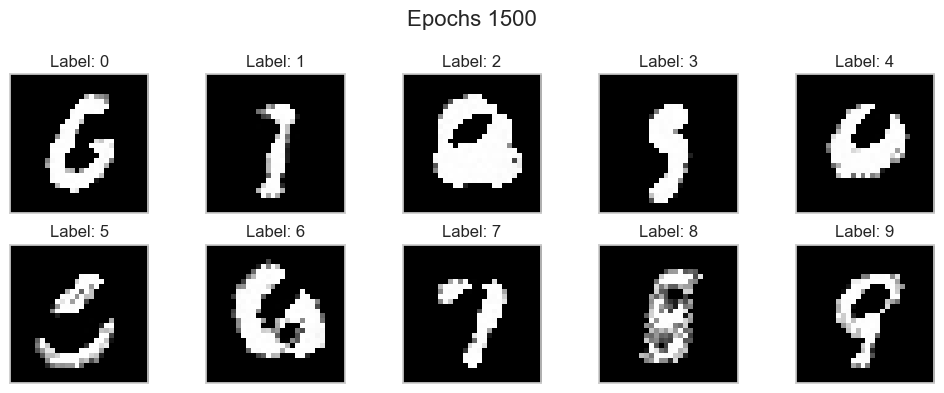

In [11]:
# load the datasets, one from each epoch
mnist_real_df = pd.read_csv('../data/real/D305-mnist.csv')
mnist_e10_df = pd.read_csv('../data/synthetic/SD305Q10_0.csv')
mnist_e100_df = pd.read_csv('../data/synthetic/SD305Q100_0.csv')
mnist_e500_df = pd.read_csv('../data/synthetic/SD305Q500_0.csv')
mnist_e1000_df = pd.read_csv('../data/synthetic/SD305Q1000_0.csv')
mnist_e1500_df = pd.read_csv('../data/synthetic/SD305Q1500_0.csv')
# Group the data by label and extract one random sample from each group
samples_real = mnist_real_df.groupby("label").apply(lambda x: x.sample(n=1)).reset_index(drop=True)
samples_e10 = mnist_e10_df.groupby("label").apply(lambda x: x.sample(n=1)).reset_index(drop=True)
samples_e100 = mnist_e100_df.groupby("label").apply(lambda x: x.sample(n=1)).reset_index(drop=True)
samples_e500 = mnist_e500_df.groupby("label").apply(lambda x: x.sample(n=1)).reset_index(drop=True)
samples_e1000 = mnist_e1000_df.groupby("label").apply(lambda x: x.sample(n=1)).reset_index(drop=True)
samples_e1500 = mnist_e1500_df.groupby("label").apply(lambda x: x.sample(n=1)).reset_index(drop=True)

samples_dict = {"Original data": samples_real, 
                "Epochs 10": samples_e10, 
                "Epochs 100": samples_e100, 
                "Epochs 500": samples_e500,  
                'Epochs 1000': samples_e1000,
                "Epochs 1500": samples_e1500
               }


for epochs, images in samples_dict.items():
    print(f"{epochs}")
    # Sorting by labels
    images = images.sort_values(by='label')
    show_mnist_img(images, epochs)


# PF measures analysis

## Hypothesis test: Specific model Spearman rank correlation coefficient test

Hypothesis test on the montictic relationship for each respective population fidelity measure and specific model performance by computing the spearman's rank correlation coefficient then use fisherman's z-transformation to compute a z-score for the hypothesis test.  

__Variables:__   
The variables used are the relative F1-score model performance $x$ of algorithm $A$ and population fidelity measure $y$. Meaning the F1-score of the model trained on synthetic data tested on original data divided by the F1-score of the model trained on the original data, i.e. $\frac{\text{F1-score synthetic}}{\text{F1-score original}}$.

__Statistical test selection:__   
The spearman's rank correlation test was chosen to examine the montictic relationship between the for the reasons of the data was noted to be non-linear and consist of continous variables.

__Hypothesis:__  
$H_0(x, A), \rho =0$: there exists no monotictic relationship between the population fidelity measure $y$ and relative F1-score $x$ for algorithm $A$.  
$H_1(x, A), \rho \ne 0$: there exists a monotictic relationship between the population fidelity measure $y$ and relative F1-score $x$ for algorithm $A$.  

__Significance level:__ 
$\alpha=0.01$, two-tailed test yields the z-value $=\pm 2.58$.

__Method:__  
scipy.stats.spearmanr will be used to compute the coefficient, then compute the z-score using fisher's z-transformation (inverse hyperbolic tangent, i.e. arctanh), from which the p-value is then derived using method described in [Tests for rank correlation coefficients I].

$H_0$ is rejected if it is within the critical range.

In [12]:
from math import sqrt
def two_tailed_p_value(z_value):
    # Computes the p-value of a two-tailed test using a z-score
    return 2 * (1 - norm.cdf(z_value)) if z_value > 0 else 2 * norm.cdf(z_value)


model_metric_str = 'F1_macro_ratio'
specific_hyptest = pd.DataFrame()

for model in result['model'].unique():

    row = {"model": model}

    for pf_str in pf_metrics:
        # if categorical pf_metric, exclude datsets with only numerical data
        if pf_str in cat_pf_metrics:
            data = result[(result['model']==model) & (result['Original id'].isin(cat_o_ids))].sort_values(by='Epochs', ascending=True)
        
        else:
            data = result[(result['model']==model)].sort_values(by='Epochs', ascending=True)
        rs = spearmanr(data[model_metric_str], data[pf_str], alternative='two-sided', nan_policy='omit')
        corr = rs.correlation

        # transform the correlation coefficient to z-value using Fisher's z-transformation
        # number of samples
        n = len(data[pf_str])
        z_value = np.arctanh(corr) * sqrt((n-3) / 1.06)
        #p-value for a two-tailed test derived from the z-score
        p_value = two_tailed_p_value(z_value)

        row[f"{pf_str} correlation"] = corr
        row[f"{pf_str} p-value"] = p_value

        ### Confidence interval using Fisher's z-transformation
        # z value for 99% confidence level
        z = 2.576
        # standard deviation
        std = 1 / (np.sqrt(n-3))

        lower = np.tanh(np.arctanh(corr) - z * std)
        upper = np.tanh(np.arctanh(corr) + z * std)

        row[f"{pf_str} c.interval"] = [round(lower, 4), round(upper,4)]


    specific_hyptest = specific_hyptest.append(row, ignore_index=True)


p_value_columns = [col for col in specific_hyptest.columns if "p-value" in col]
z_value_columns = [col for col in specific_hyptest.columns if "z-value" in col]
corr_columns = [col for col in specific_hyptest.columns if "correlation" in col]
interval_columns = [col for col in specific_hyptest.columns if "c.interval" in col]

corr_p_val_cols = corr_columns + p_value_columns + interval_columns + ['model']
data = specific_hyptest[corr_p_val_cols]

# Extract the column names for the MultiIndex transformation
multiindex_cols = [(col.split()[0], col.split()[1]) for col in data.columns if ' ' in col]

# Convert the columns to a MultiIndex
data_columns = [col[0] + " " + col[1] for col in multiindex_cols] + ['model']

# Convert the relevant columns to a MultiIndex
data.columns = pd.MultiIndex.from_tuples(multiindex_cols + [('model', '')], names=['Population Fidelity Measure', 'Metric'])

# Set 'model' as the index
data = data.reset_index().set_index('model')

# Reorganize the columns so that each population fidelity measure occurs once with two sub-columns (correlation and p-value)
sorted_columns = []
for col in specific_hyptest.columns:
    if 'correlation' in col:
        measure = col.split()[0]
        sorted_columns.append((measure, 'correlation'))
        sorted_columns.append((measure, 'p-value'))
        sorted_columns.append((measure, 'c.interval'))

# Reorder the dataframe based on the sorted columns
data = data[sorted_columns]
data = data.reindex(models)
specific_hyptest = data.copy()

pd.options.display.float_format = '{:.4f}'.format
#pd.reset_option('display.float_format')
# Convert the DataFrame to LaTeX table format
latex_table = specific_hyptest.to_latex(f'{figures_fp}specific_hyptest.tex')

display(specific_hyptest)

Population Fidelity Measure BNLogLikelihood                             \
Metric                          correlation p-value         c.interval   
model                                                                    
knn                                  0.2409  0.0038   [0.0333, 0.4286]   
o_knn                                0.0988  0.2429  [-0.1128, 0.3019]   
lr                                  -0.0090  0.9152   [-0.218, 0.2007]   
o_lr                                 0.0783  0.3555   [-0.1332, 0.283]   
rf                                   0.6166  0.0000   [0.4676, 0.7315]   
o_rf                                 0.5875  0.0000   [0.4313, 0.7096]   
svm                                 -0.0426  0.6160  [-0.2497, 0.1683]   
o_svm                               -0.0724  0.3928   [-0.2776, 0.139]   

Population Fidelity Measure Cluster_G_1                              \
Metric                      correlation p-value          c.interval   
model                                                                 
knn                             -0.6631  0.0000  [-0.7453, -0.5611]   
o_knn                           -0.6362  0.0000  [-0.7238, -0.5283]   
lr                              -0.6030  0.0000  [-0.6971, -0.4884]   
o_lr                            -0.5916  0.0000   [-0.688, -0.4748]   
rf                              -0.4236  0.0000  [-0.5484, -0.2805]   
o_rf                            -0.3202  0.0000  [-0.4588, -0.1665]   
svm                             -0.5870  0.0000  [-0.6842, -0.4693]   
o_svm                           -0.5012  0.0000  [-0.6137, -0.3688]   

Population Fidelity Measure ContinousKLDivergence                             \
Metric                                correlation p-value         c.interval   
model                                                                          
knn                                        0.3567  0.0000   [0.2062, 0.4907]   
o_knn                                      0.2666  0.0000   [0.1088, 0.4112]   
lr                                         0.3814  0.0000   [0.2334, 0.5122]   
o_lr                                       0.3520  0.0000    [0.201, 0.4866]   
rf                                         0.2065  0.0014    [0.0456, 0.357]   
o_rf                                       0.0096  0.8830  [-0.1531, 0.1718]   
svm                                        0.3040  0.0000   [0.1489, 0.4445]   
o_svm                                      0.2835  0.0000   [0.1269, 0.4263]   

Population Fidelity Measure        CrCl                                CSTest  \
Metric                      correlation p-value        c.interval correlation   
model                                                                           
knn                              0.4720  0.0000  [0.3353, 0.5893]      0.5350   
o_knn                            0.3394  0.0000  [0.1873, 0.4756]      0.4691   
lr                               0.4590  0.0000  [0.3204, 0.5783]      0.4462   
o_lr                             0.4878  0.0000  [0.3534, 0.6025]      0.4514   
rf                               0.6086  0.0000  [0.4951, 0.7017]      0.5413   
o_rf                             0.5559  0.0000  [0.4325, 0.6589]      0.4700   
svm                              0.3969  0.0000  [0.2506, 0.5255]      0.3742   
o_svm                            0.4392  0.0000   [0.298, 0.5616]      0.3620   

Population Fidelity Measure                           DiscreteKLDivergence  \
Metric                      p-value        c.interval          correlation   
model                                                                        
knn                          0.0000  [0.3667, 0.6693]               0.3631   
o_knn                        0.0000   [0.288, 0.6177]               0.2747   
lr                           0.0000  [0.2613, 0.5995]               0.2551   
o_lr                         0.0000  [0.2673, 0.6036]               0.2715   
rf                           0.0000  [0.3744, 0.6742]               0.7172   
o_rf  

In [59]:
specific_hyptest[['BNLogLikelihood', 'Cluster_G_1', 'ContinousKLDivergence']].to_latex(f'{figures_fp}specific_hyptest_subtable_1.tex')
specific_hyptest[['CrCl', 'CSTest', 'DiscreteKLDivergence']].to_latex(f'{figures_fp}specific_hyptest_subtable_2.tex')
specific_hyptest[['GMLogLikelihood', 'KSComplement', 'pMSE']].to_latex(f'{figures_fp}specific_hyptest_subtable_3.tex')

## Hypothesis test: General model Spearman rank correlation coefficient test

Hypothesis test on the montictic relationship for each respective population fidelity measure and general model performance by computing the spearman's rank correlation coefficient then use fisherman's z-transformation to compute a z-score for the hypothesis test.  

__Variables:__   
The variables used are the general relative F1-score model performance $x$ and population fidelity measure $y$. General relative F1-score performance is the mean performance of all models trained on synthetic datasets divided by the model with the highest mean performance over all original datasets, i.e. $\frac{\text{mean F1-score on synthetic}}{\text{best mean F1-score on original}}$.

__Statistical test selection:__   
The spearman's rank correlation test was chosen to examine the montictic relationship between the for the reasons of the data being noted as non-linear and consist of continous variables.

__Hypothesis:__  
$H_0(x, A), \rho =0$: there exists no monotictic relationship between the population fidelity measure $y$ and relative F1-score $x$ for the algorithms \ac{knn}, \ac{lr}, \ac{rf} and \ac{svm}.  
$H_1(x, A), \rho \ne 0$: there exists a monotictic relationship between the population fidelity measure $y$ and relative F1-score $x$ for the algorithms \ac{knn}, \ac{lr}, \ac{rf} and \ac{svm}.  

__Significance level:__ 
$\alpha=0.01$ on a two-tailed test 

__Method:__  
scipy.stats.spearmanr will be used to compute the coefficient, then the fisher's z-transformation (inverse hyperbolic tangent, i.e. arctanh) to compute the z-score.

$H_0$ is rejected if it is within the critical range.

In [13]:

model_metric_str = 'F1_macro_ratio'
general_hyptest = pd.DataFrame()

for pf_str in pf_metrics:
    # if categorical pf_metric, exclude numerical datasets
    if pf_str in cat_pf_metrics:
        data = result[(result['Original id'].isin(cat_o_ids))]
    else:
        data = result.copy()

    rs =  spearmanr(data[pf_str], data[model_metric_str], alternative='two-sided', nan_policy='omit')

    row = {}
    corr = rs.correlation

    row[f"Measure"] = pf_str
    row[f"correlation"] = corr
    row[f"p-value"] = rs.pvalue 

    ### Confidence interval using Fisher's z-transformation for spearmans'r
    # sample size 
    n = len(data[pf_str])
    # standard deviation
    std = 1 / (np.sqrt(n-3))

    # Z value for 99% confidence interval
    z = 2.576

    lower = np.tanh(np.arctanh(corr) - z * std)
    upper = np.tanh(np.arctanh(corr) + z * std)

    row["c.interval"] = [round(lower,4), round(upper,4)]
    

    general_hyptest = general_hyptest.append(row, ignore_index=True)

# Set 'Measure' as the index
general_hyptest = general_hyptest.set_index('Measure')

# Convert the DataFrame to LaTeX table format
latex_table = general_hyptest.to_latex(f'{figures_fp}general_hyptest.tex')

display(general_hyptest)

correlation  p-value          c.interval
Measure                                                        
BNLogLikelihood             0.1761   0.0000    [0.1031, 0.2471]
Cluster_G_1                -0.5370   0.0000  [-0.5767, -0.4947]
ContinousKLDivergence       0.2596   0.0000    [0.2051, 0.3125]
CrCl                        0.4619   0.0000     [0.4154, 0.506]
CSTest                      0.4300   0.0000    [0.3674, 0.4887]
DiscreteKLDivergence        0.3414   0.0000    [0.2741, 0.4055]
GMLogLikelihood             0.0526   0.0188    [-0.005, 0.1098]
KSComplement                0.4425   0.0000     [0.395, 0.4876]
pMSE                       -0.4589   0.0000  [-0.5032, -0.4122]

## pMSE analysis

### vs Epochs on all datasets

In [14]:
### Older plot
#x_axis = 'Epochs'
#y_axis = 'pMSE'
#
## Get unique original datasets
#o_ids = list(datasetnames.values()) # result['Original id'].unique()
#
## Create a 1x2 grid for the subplots
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 9))
#
#fig.suptitle(f"{y_axis} for each synthetic dataset", fontsize=24)
#
## Plot the first graph on ax1
#for data_id in o_ids:
#    data = result[result['Original id'] == data_id]
#    sns.lineplot(x=x_axis, y=y_axis, data=data, label=data_id, ax=ax1)
#
## Define ticks for the first graph
#unique_epochs = data['Epochs'].unique().astype(int)
#ax1.set_xticks(unique_epochs)
#ax1.set_xlabel(x_axis, fontsize=20)
#ax1.set_ylabel(y_axis, fontsize=20)
#ax1.legend().remove()
#ax1.axhline(y=0.5, linewidth=2, color='grey', ls=':')
#ax1.text(-50, 0.5, "0.5", color='grey', ha='left', va='bottom') 
#
## Plot the second graph on ax2
#for data_id in o_ids:
#    data = result[result['Original id'] == data_id]
#    sns.lineplot(x=x_axis, y=y_axis, data=data, label=data_id, ax=ax2)
#
## Define ticks for the second graph
#ax2.set_xticks(unique_epochs)
#ax2.set_xlabel(x_axis, fontsize=20)
#ax2.set_ylabel("")
#ax2.legend(title='Dataset name', bbox_to_anchor=(1, 1.03), loc='upper left', fontsize=20)
#ax2.axhline(y=0.5, linewidth=2, color='grey', ls=':')
#ax2.text(-50, 0.5, "0.5", color='grey', ha='left', va='bottom') 
#ax2.set_ylim(0, 8)
#
#plt.tight_layout()
##plt.savefig(f"{figures_fp}{x_axis}_vs_{y_axis}.png", bbox_inches='tight', dpi=500)
#plt.show()
#

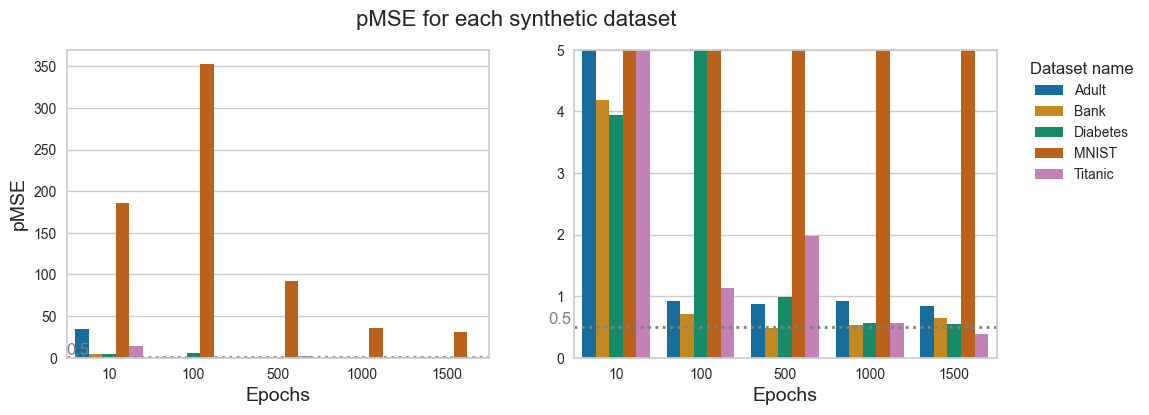

In [15]:
x_axis = 'Epochs'
y_axis = 'pMSE'

data = grouped_result.copy()
# Get unique original datasets
o_ids = list(datasetnames.values()) # result['Original id'].unique()

# Create a 1x2 grid for the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_large_pf_epochs_size)

fig.suptitle(f"{y_axis} for each synthetic dataset", fontsize=fig_pf_epochs_title_size)

# Plot barplots on both axes
sns.barplot(data=data, x=x_axis, y=y_axis, hue='Original id', hue_order=o_ids, ax=ax1)
sns.barplot(data=data, x=x_axis, y=y_axis, hue='Original id', hue_order=o_ids, ax=ax2)

# Define ticks for the first graph
ax1.set_xlabel(x_axis, fontsize=fig_pf_e_axel_label_size)
ax1.set_ylabel(y_axis, fontsize=fig_pf_e_axel_label_size)
ax1.legend().remove()
ax1.axhline(y=0.5, linewidth=2, color='grey', ls=':')
ax1.text(-0.5, 0.5, "0.5", color='grey', ha='left', va='bottom') 

# Define ticks for the second graph
ax2.set_xlabel(x_axis, fontsize=fig_pf_e_axel_label_size)
ax2.set_ylabel("")
ax2.legend(title='Dataset name', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.axhline(y=0.5, linewidth=2, color='grey', ls=':')
ax2.text(-0.8, 0.5, "0.5", color='grey', ha='left', va='bottom') 
ax2.set_ylim(0, 5)  # Changed the y limit to match the scale of the random data

# Display the plot
plt.savefig(f"{figures_fp}{x_axis}_vs_{y_axis}.png", bbox_inches='tight', dpi=fig_large_dpi)
plt.show()

### vs Performance of all datasets and models

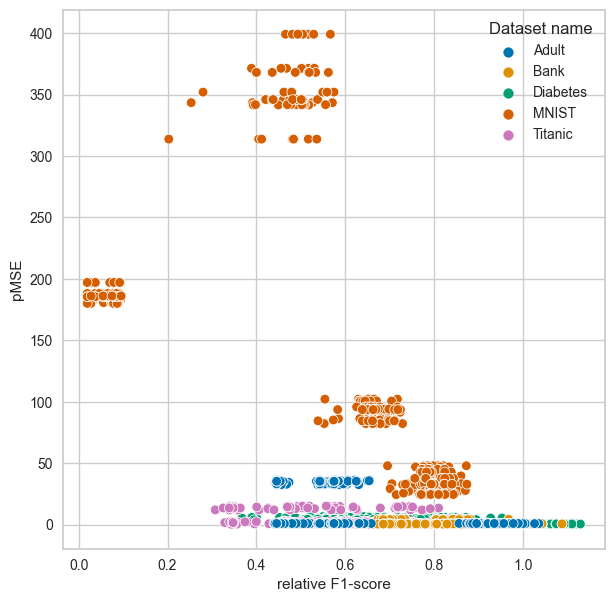

In [16]:
x_axis = 'F1_macro_ratio'
y_axis = 'pMSE'

# Create a single figure
plt.figure(figsize=(7,7))

# Plot data for all models and datasets on the same plot
sns.scatterplot(x=x_axis, y=y_axis, data=result, hue='Original id', hue_order=list(datasetnames.values()))
# Add labels and title
plt.xlabel('relative F1-score')
plt.ylabel(y_axis)
#plt.title(f"{y_axis} vs relative F1-score", fontsize=20)


# Add legend
plt.legend(title='Dataset name', loc='upper right')


plt.savefig(f"{figures_fp}{y_axis}_vs_overall_{x_axis}.png", bbox_inches='tight', dpi=300)
plt.show()


### vs Performance of all datasets for each model

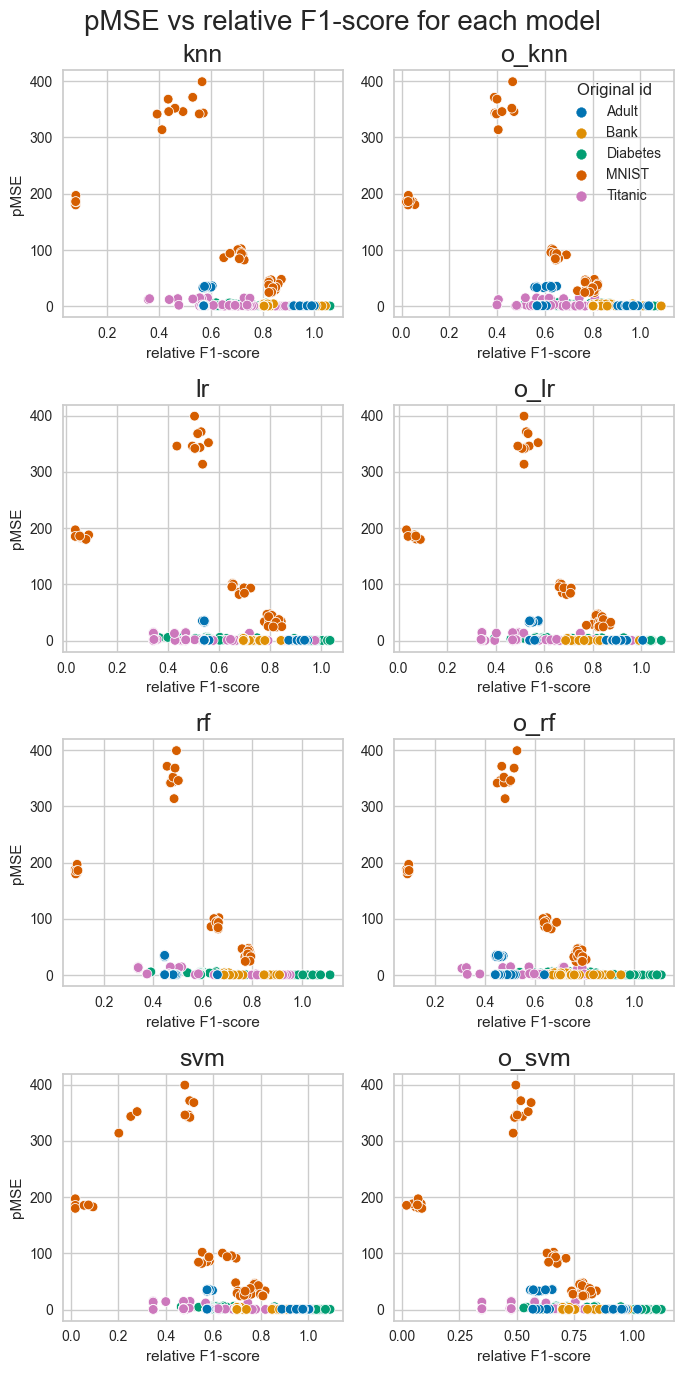

In [17]:
y_axis = 'pMSE'
x_axis = 'F1_macro_ratio'
data = result.copy()
# Set up the 4x2 grid plot
fig, axes = plt.subplots(4, 2, figsize=(7, 14))
fig.suptitle(f"{y_axis} vs relative F1-score for each model", fontsize=20)

axes = axes.flatten()
ax_num = 0 

# Iterate over each model and each subplot axis
for ax, model in zip(axes, models):
    filtered_data = data[data['model']==model]
    sns.scatterplot(x=x_axis, y=y_axis, data=filtered_data, ax=ax, hue='Original id', hue_order=list(datasetnames.values()))
    ax.set_title(model, fontsize=18)

    if ax_num != 1:
        ax.legend().remove()

    if ax_num % 2 == 0:
        ax.set_ylabel(y_axis) 
    else:
        ax.set_ylabel('')
    ax.set_xlabel("relative F1-score")

    ax_num += 1

# Adjust layout
plt.tight_layout()
plt.savefig(f"{figures_fp}{y_axis}_vs_{x_axis}.png", bbox_inches='tight', dpi=300)
plt.show()


## Cluster analysis

### vs Epochs on all datasets

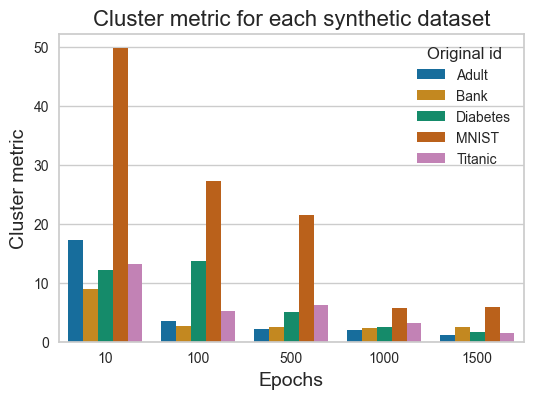

In [18]:
x_axis = 'Epochs'
y_axis = 'Cluster_G_1'

# o_ids defined in pMSE 

plt.figure(figsize=fig_pf_epochs_size)

# Iterate through unique original datasets
#for data_id in o_ids:
#    # Create a new dataframe with only the current original dataset
#    data = result[result['Original id'] == data_id]
#    ax = sns.lineplot(x=x_axis, y=y_axis,
#                      data=data, marker='x',
#                      label=data_id,
#    )
sns.barplot(data=grouped_result, x=x_axis, y=y_axis, hue='Original id', hue_order=o_ids)

# Define ticks
unique_epochs = data['Epochs'].unique().astype(int)

# Add labels and title
plt.xlabel(x_axis, fontsize=fig_pf_e_axel_label_size)
#plt.xticks(data['Epochs'].unique())
plt.ylabel("Cluster metric", fontsize=fig_pf_e_axel_label_size)
plt.title(f"Cluster metric for each synthetic dataset", fontsize=fig_pf_epochs_title_size)

# Display the plot
plt.savefig(f"{figures_fp}{x_axis}_vs_{y_axis}.png", bbox_inches='tight', dpi=fig_pf_epochs_dpi)
plt.show()

### vs Performance of all datasets and models

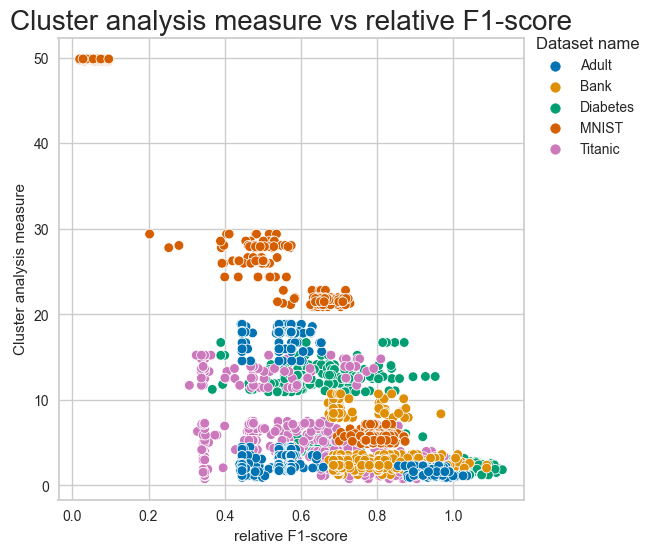

In [19]:
x_axis = 'F1_macro_ratio'
y_axis = 'Cluster_G_1'

# Create a single figure
plt.figure(figsize=(6,6))

# Plot data for all models and datasets on the same plot
sns.scatterplot(x=x_axis, y=y_axis, data=result, hue='Original id', hue_order=o_ids)
# Add labels and title
plt.xlabel('relative F1-score')
plt.ylabel("Cluster analysis measure")
plt.title(f"Cluster analysis measure vs relative F1-score", fontsize=20)


# Add legend
plt.legend(title='Dataset name', bbox_to_anchor=(1, 1.03), loc='upper left')


plt.savefig(f"{figures_fp}{y_axis}_vs_overall_{x_axis}.png", bbox_inches='tight', dpi=300)
plt.show()


### vs Performance of all datasets for each model

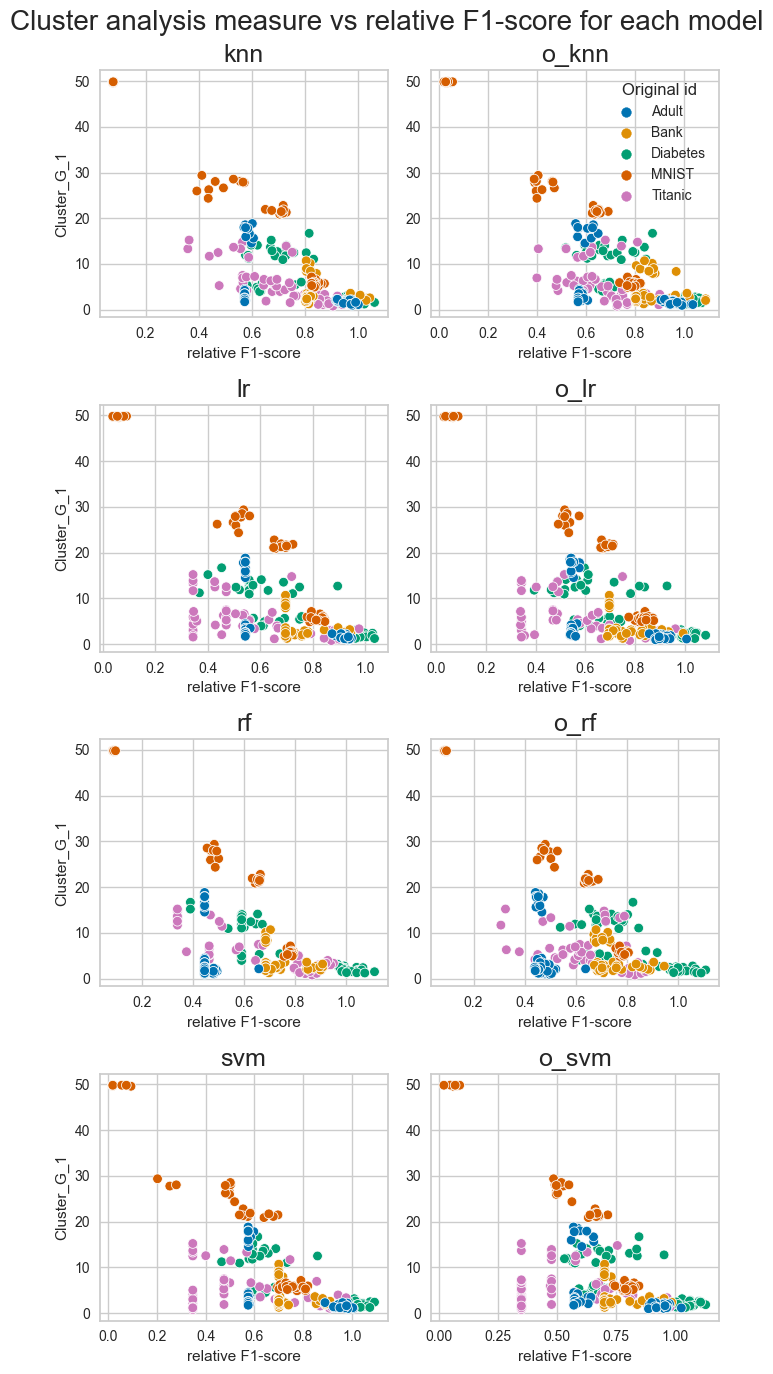

In [20]:
y_axis = 'Cluster_G_1'
x_axis = 'F1_macro_ratio'
data = result.copy()
# Set up the 4x2 grid plot
fig, axes = plt.subplots(4, 2, figsize=(7, 14))
fig.suptitle(f"Cluster analysis measure vs relative F1-score for each model", fontsize=20)
axes = axes.flatten()
ax_num = 0 


# Iterate over each model and each subplot axis
for ax, model in zip(axes, models):
    filtered_data = data[data['model']==model]
    sns.scatterplot(x=x_axis, y=y_axis, data=filtered_data, ax=ax, hue='Original id', hue_order=o_ids)
    ax.set_title(model, fontsize=18)

    if ax_num != 1:
        ax.legend().remove()
    if ax_num % 2 == 0:
        ax.set_ylabel(y_axis) 
    else:
        ax.set_ylabel('')
    ax.set_xlabel("relative F1-score")

    ax_num += 1

# Adjust layout
plt.tight_layout()
plt.savefig(f"{figures_fp}{y_axis}_vs_{x_axis}.png", bbox_inches='tight', dpi=300)
plt.show()

### Spearman rank correlation coefficent test

In [21]:
specific_hyptest['Cluster_G_1']

Metric  correlation  p-value          c.interval
model                                           
knn         -0.6631   0.0000  [-0.7453, -0.5611]
o_knn       -0.6362   0.0000  [-0.7238, -0.5283]
lr          -0.6030   0.0000  [-0.6971, -0.4884]
o_lr        -0.5916   0.0000   [-0.688, -0.4748]
rf          -0.4236   0.0000  [-0.5484, -0.2805]
o_rf        -0.3202   0.0000  [-0.4588, -0.1665]
svm         -0.5870   0.0000  [-0.6842, -0.4693]
o_svm       -0.5012   0.0000  [-0.6137, -0.3688]

## BNLogLikelihood analysis

### Epochs for each datset

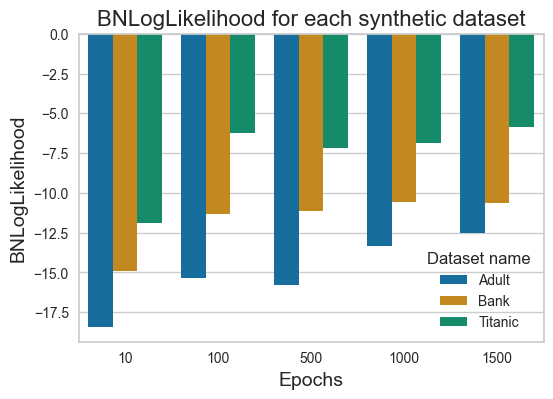

In [22]:
x_axis = 'Epochs'
y_axis = 'BNLogLikelihood'

# o_ids defined in pMSE 
data = grouped_result[(grouped_result['Original id'].isin(cat_o_ids))]


plt.figure(figsize=fig_pf_epochs_size)

# Iterate through unique original datasets
sns.barplot(x=x_axis, y=y_axis, data=data, hue='Original id', hue_order=cat_o_ids)



# Define ticks
unique_epochs = data['Epochs'].unique().astype(int)

# Add labels and title
plt.xlabel(x_axis, fontsize=fig_pf_e_axel_label_size)
plt.ylabel(y_axis, fontsize=fig_pf_e_axel_label_size)
plt.title(f"{y_axis} for each synthetic dataset", fontsize=fig_pf_epochs_title_size)

# Add legend
plt.legend(title='Dataset name', loc='lower right')


# Display the plot
plt.savefig(f"{figures_fp}{x_axis}_vs_{y_axis}.png", bbox_inches='tight', dpi=fig_pf_epochs_dpi)
plt.show()

### vs Performance of all datasets and models

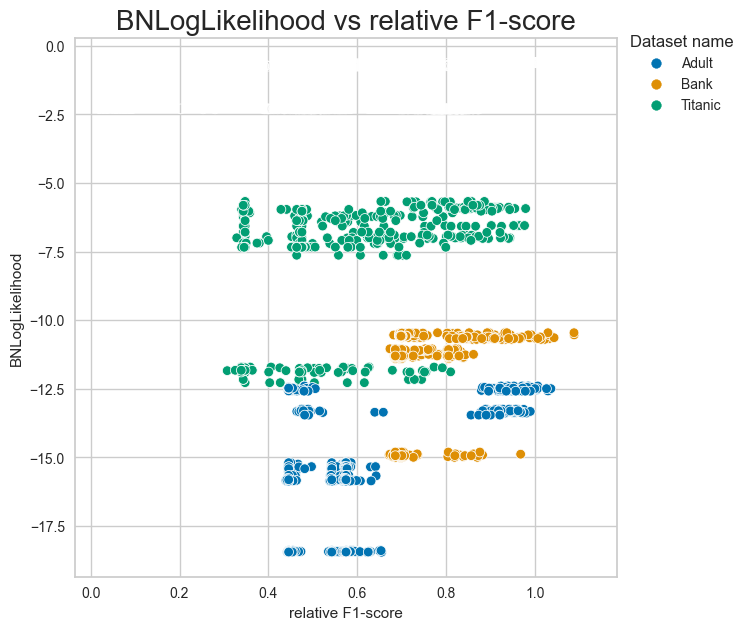

In [23]:
x_axis = 'F1_macro_ratio'
y_axis = 'BNLogLikelihood'

# Create a single figure
plt.figure(figsize=(7,7))

# Plot data for all models and datasets on the same plot
sns.scatterplot(x=x_axis, y=y_axis, data=result, hue='Original id', hue_order=cat_o_ids)
# Add labels and title
plt.xlabel('relative F1-score')
plt.ylabel(y_axis)
plt.title(f"{y_axis} vs relative F1-score", fontsize=20)


# Add legend
plt.legend(title='Dataset name', bbox_to_anchor=(1, 1.03), loc='upper left')


plt.savefig(f"{figures_fp}{y_axis}_vs_overall_{x_axis}.png", bbox_inches='tight', dpi=300)
plt.show()


### Performance of all dataset for each model

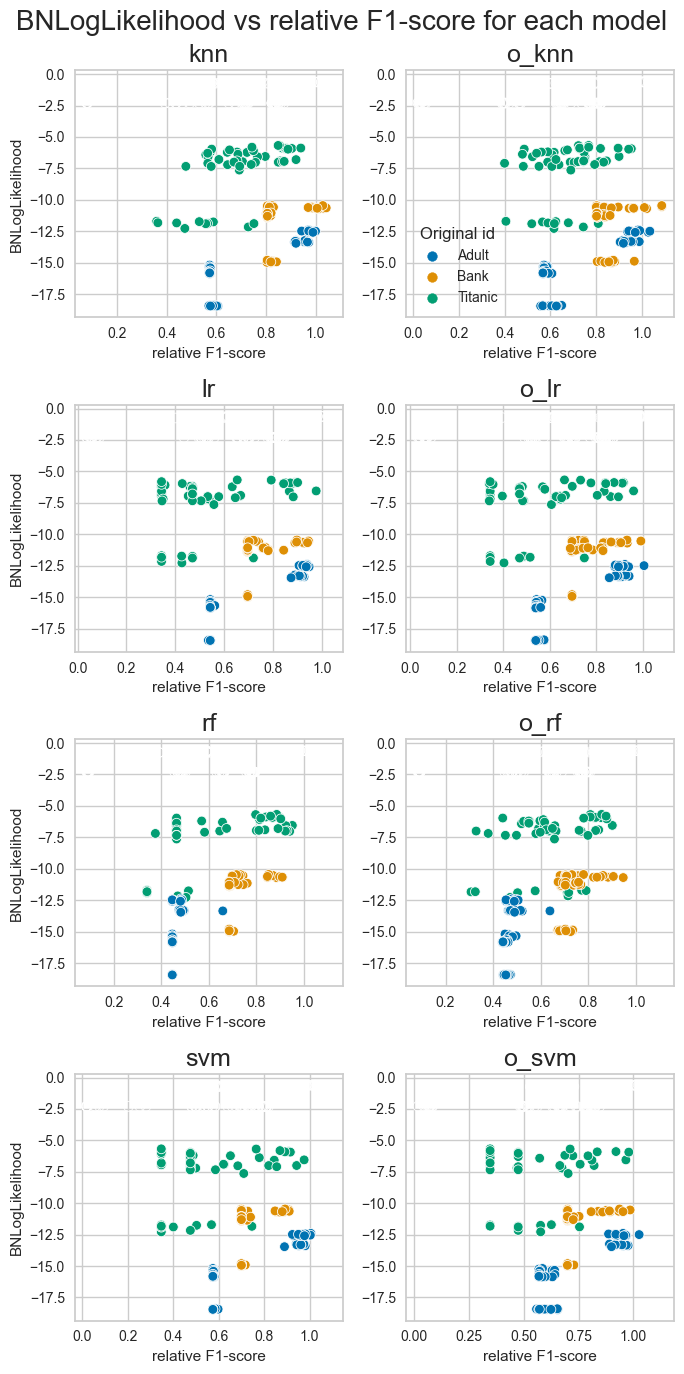

In [24]:
y_axis = 'BNLogLikelihood'
x_axis = 'F1_macro_ratio'
data = result.copy()
# Set up the 4x2 grid plot
fig, axes = plt.subplots(4, 2, figsize=(7,14))
fig.suptitle(f"{y_axis} vs relative F1-score for each model", fontsize=20)
axes = axes.flatten()
ax_num = 0 


# Iterate over each model and each subplot axis
for ax, model in zip(axes, models):
    filtered_data = data[data['model']==model]
    sns.scatterplot(x=x_axis, y=y_axis, data=filtered_data, ax=ax, hue='Original id', hue_order=cat_o_ids)
    ax.set_title(model, fontsize=18)

    if ax_num != 1:
        ax.legend().remove()
    if ax_num % 2 == 0:
        ax.set_ylabel(y_axis) 
    else:
        ax.set_ylabel('')
    ax.set_xlabel("relative F1-score")

    ax_num += 1

# Adjust layout
plt.tight_layout()
plt.savefig(f"{figures_fp}{y_axis}_vs_{x_axis}.png", bbox_inches='tight', dpi=300)
plt.show()

### Spearman rank correlation coeficient test

In [25]:
specific_hyptest['BNLogLikelihood']

Metric  correlation  p-value         c.interval
model                                          
knn          0.2409   0.0038   [0.0333, 0.4286]
o_knn        0.0988   0.2429  [-0.1128, 0.3019]
lr          -0.0090   0.9152   [-0.218, 0.2007]
o_lr         0.0783   0.3555   [-0.1332, 0.283]
rf           0.6166   0.0000   [0.4676, 0.7315]
o_rf         0.5875   0.0000   [0.4313, 0.7096]
svm         -0.0426   0.6160  [-0.2497, 0.1683]
o_svm       -0.0724   0.3928   [-0.2776, 0.139]

## GMLogLikelihood

### vs Epochs for each dataset

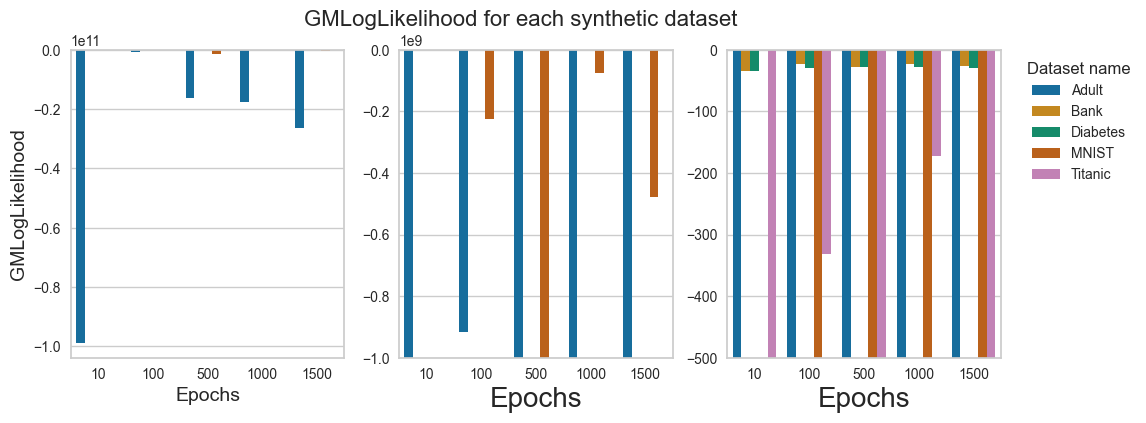

In [26]:
x_axis = 'Epochs'
y_axis = 'GMLogLikelihood'

data = grouped_result.copy()
# Get unique original datasets
o_ids = list(datasetnames.values()) # result['Original id'].unique()

# Create a 1x2 grid for the subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=fig_large_pf_epochs_size)

fig.suptitle(f"{y_axis} for each synthetic dataset", fontsize=fig_pf_epochs_title_size)

# Plot barplots on both axes
sns.barplot(data=data, x=x_axis, y=y_axis, hue='Original id', hue_order=o_ids, ax=ax1)
sns.barplot(data=data, x=x_axis, y=y_axis, hue='Original id', hue_order=o_ids, ax=ax2)
sns.barplot(data=data, x=x_axis, y=y_axis, hue='Original id', hue_order=o_ids, ax=ax3)

ax1.set_xlabel(x_axis, fontsize=fig_pf_e_axel_label_size)
ax1.set_ylabel(y_axis, fontsize=fig_pf_e_axel_label_size)
ax1.legend().remove()

ax2.set_xlabel(x_axis, fontsize=20)
ax2.set_ylabel("")
ax2.set_ylim(-1000000000, 0.0)  # Changed the y limit to match the scale of the random data
ax2.legend().remove()

ax3.set_xlabel(x_axis, fontsize=20)
ax3.set_ylabel("")
ax3.legend(title='Dataset name', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.set_ylim(-500, 0.0)  # Changed the y limit to match the scale of the random data

# Display the plot
plt.savefig(f"{figures_fp}{x_axis}_vs_{y_axis}.png", bbox_inches='tight', dpi=fig_large_dpi)
plt.show()

### vs Performance of all datasets and models

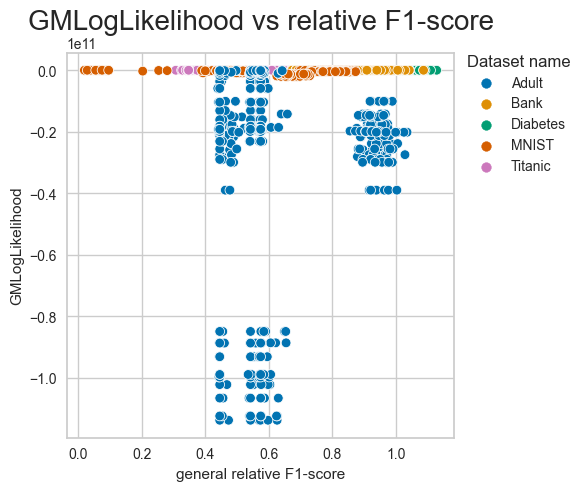

In [27]:
x_axis = 'F1_macro_ratio'
y_axis = 'GMLogLikelihood'

# Create a single figure
plt.figure(figsize=(5,5))

# Plot data for all models and datasets on the same plot
sns.scatterplot(x=x_axis, y=y_axis, data=result, hue='Original id', hue_order=o_ids)
# Add labels and title
plt.xlabel('general relative F1-score')
plt.ylabel(y_axis)
plt.title(f"{y_axis} vs relative F1-score", fontsize=20)


# Add legend
plt.legend(title='Dataset name', bbox_to_anchor=(1, 1.03), loc='upper left')


plt.savefig(f"{figures_fp}{y_axis}_vs_overall_{x_axis}.png", bbox_inches='tight', dpi=300)
plt.show()


### vs Performance of all dataset for each model

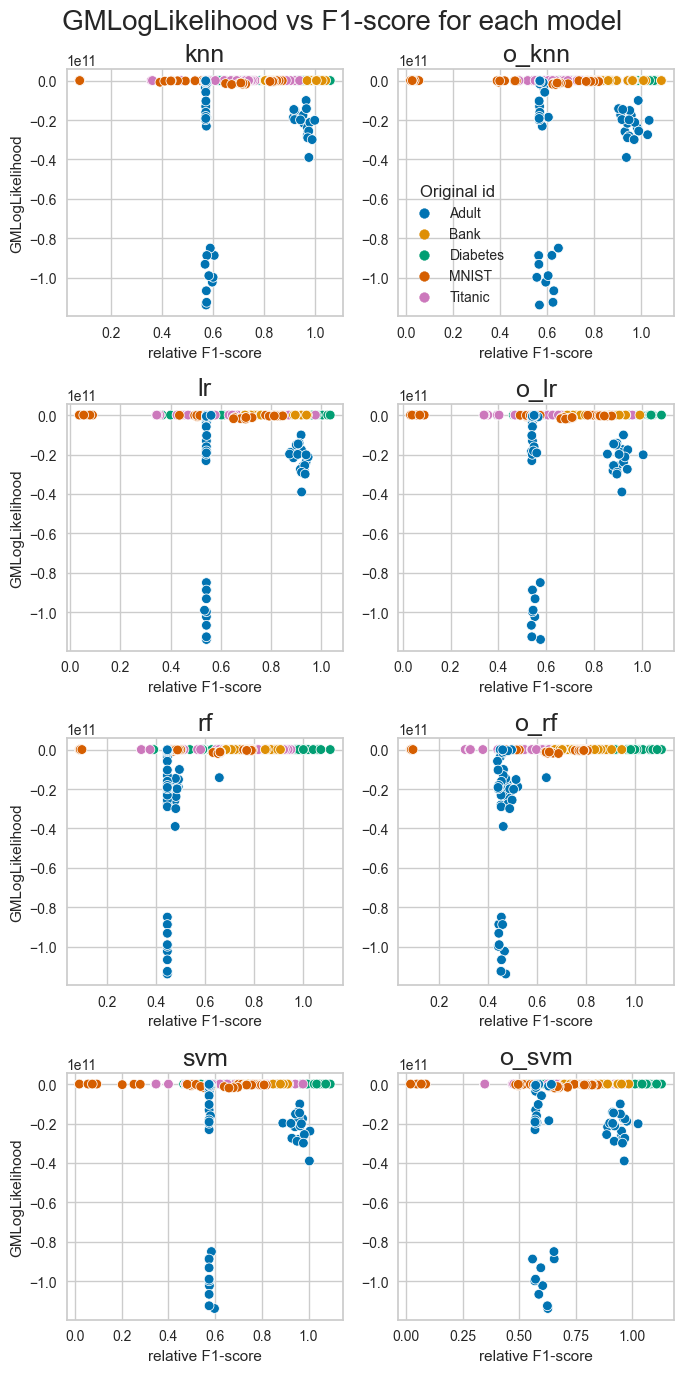

In [28]:
x_axis = 'F1_macro_ratio'
y_axis = 'GMLogLikelihood'

data = result.copy()
# Set up the 4x2 grid plot
fig, axes = plt.subplots(4, 2, figsize=(7,14))
fig.suptitle(f"{y_axis} vs F1-score for each model", fontsize=20)
axes = axes.flatten()
ax_num = 0 


# Iterate over each model and each subplot axis
for ax, model in zip(axes, models):
    filtered_data = data[data['model']==model]
    sns.scatterplot(x=x_axis, y=y_axis, data=filtered_data, ax=ax, hue='Original id', hue_order=o_ids)
    ax.set_title(model, fontsize=18)

    if ax_num != 1:
        ax.legend().remove()
    if ax_num % 2 == 0:
        ax.set_ylabel(y_axis) 
    else:
        ax.set_ylabel('')
    ax.set_xlabel("relative F1-score")

    ax_num += 1

# Adjust layout
plt.tight_layout()
plt.savefig(f"{figures_fp}{y_axis}_vs_{x_axis}.png", bbox_inches='tight', dpi=300)
plt.show()

## KLDivergence

### ContinousKLDivergence vs Epochs for each dataset

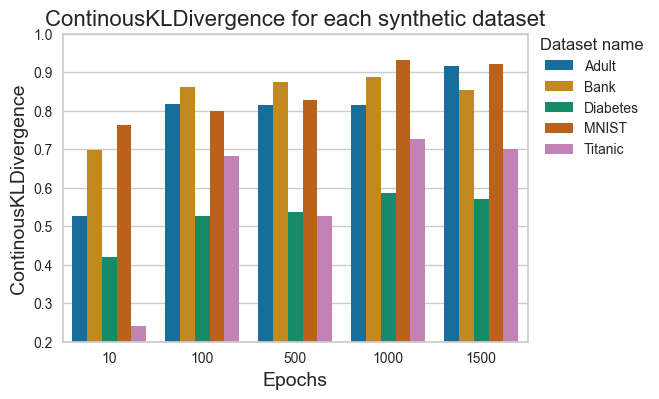

In [29]:
x_axis = 'Epochs'
y_axis = 'ContinousKLDivergence'

# o_ids defined in pMSE 
data = grouped_result.copy()


plt.figure(figsize=fig_pf_epochs_size)

# Iterate through unique original datasets
sns.barplot(x=x_axis, y=y_axis, data=data, hue='Original id', hue_order=o_ids)

# Add labels and title
plt.xlabel(x_axis, fontsize=fig_pf_e_axel_label_size)
plt.ylabel(y_axis, fontsize=fig_pf_e_axel_label_size)
plt.title(f"{y_axis} for each synthetic dataset", fontsize=fig_pf_epochs_title_size)

plt.ylim(0.2,1)

# Add legend
plt.legend(title='Dataset name', loc='upper left', bbox_to_anchor=(1, 1.03))


# Display the plot
plt.savefig(f"{figures_fp}{x_axis}_vs_{y_axis}.png", bbox_inches='tight', dpi=fig_pf_epochs_dpi)
plt.show()

### vs Performance of all datasets and models

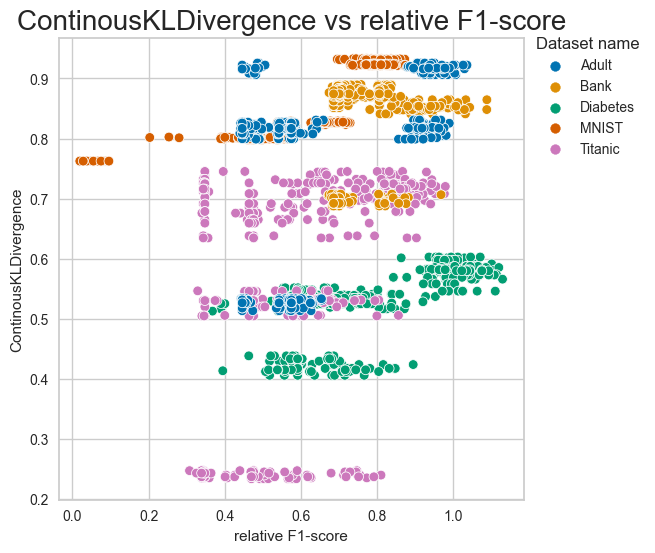

In [30]:
x_axis = 'F1_macro_ratio'
y_axis = 'ContinousKLDivergence'

# Create a single figure
plt.figure(figsize=(6,6))

# Plot data for all models and datasets on the same plot
sns.scatterplot(x=x_axis, y=y_axis, data=result, hue='Original id', hue_order=o_ids)
# Add labels and title
plt.xlabel('relative F1-score')
plt.ylabel(y_axis)
plt.title(f"{y_axis} vs relative F1-score", fontsize=20)


# Add legend
plt.legend(title='Dataset name', bbox_to_anchor=(1, 1.03), loc='upper left')


plt.savefig(f"{figures_fp}{y_axis}_vs_overall_{x_axis}.png", bbox_inches='tight', dpi=300)
plt.show()


### ContinousKLDivergence vs Performance of all dataset for each model

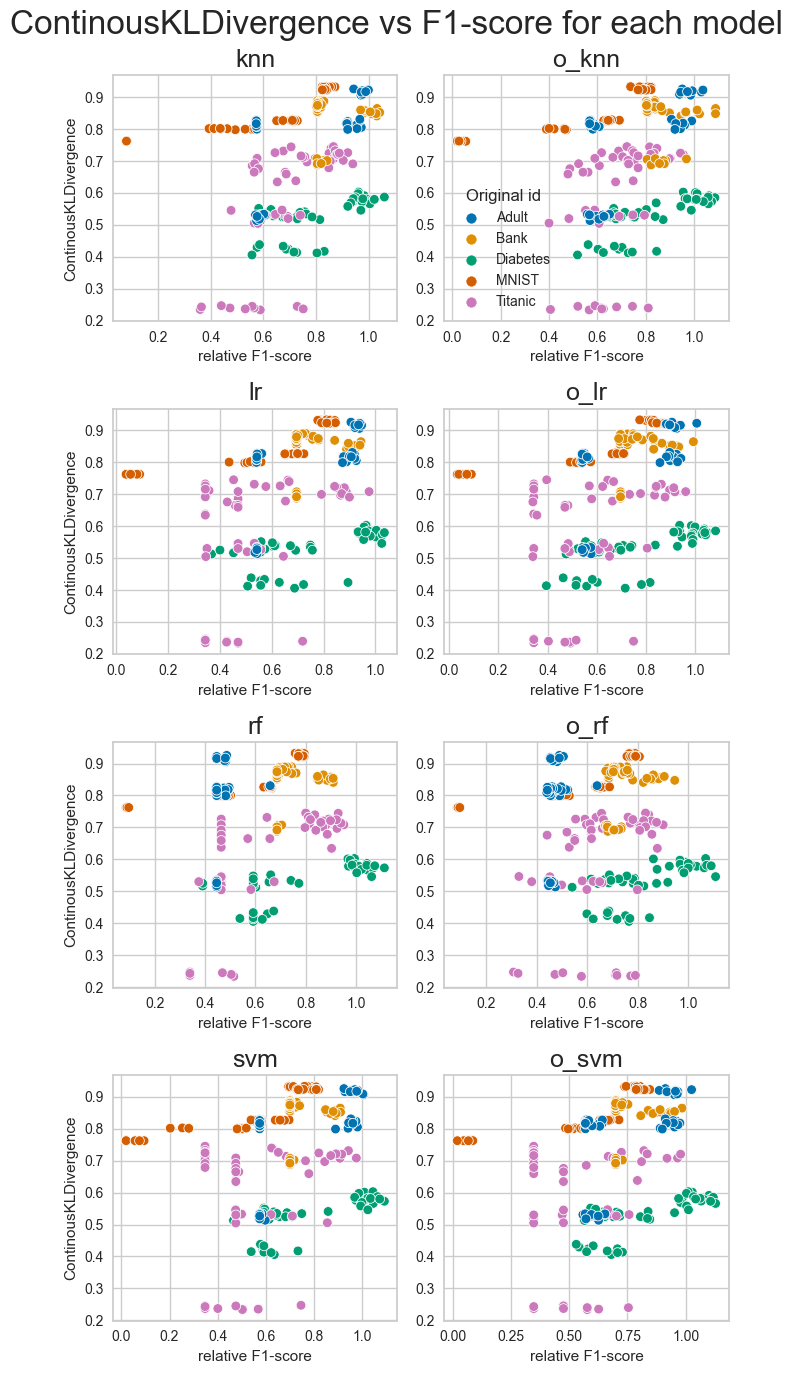

In [31]:
x_axis = 'F1_macro_ratio'
y_axis = 'ContinousKLDivergence'

data = result.copy()
# Set up the 4x2 grid plot
fig, axes = plt.subplots(4, 2, figsize=(7, 14))
fig.suptitle(f"{y_axis} vs F1-score for each model", fontsize=24)
axes = axes.flatten()
ax_num = 0 


# Iterate over each model and each subplot axis
for ax, model in zip(axes, models):
    filtered_data = data[data['model']==model]
    sns.scatterplot(x=x_axis, y=y_axis, data=filtered_data, ax=ax, hue='Original id', hue_order=o_ids)
    ax.set_title(model, fontsize=18)

    if ax_num != 1:
        ax.legend().remove()
    if ax_num % 2 == 0:
        ax.set_ylabel(y_axis) 
    else:
        ax.set_ylabel('')
    ax.set_xlabel("relative F1-score")

    ax_num += 1

# Adjust layout
plt.tight_layout()
plt.savefig(f"{figures_fp}{y_axis}_vs_{x_axis}.png", bbox_inches='tight', dpi=300)
plt.show()

### Spearman rank correlation coeficient test

In [32]:
pf_str = 'ContinousKLDivergence'
specific_hyptest[pf_str]

Metric  correlation  p-value         c.interval
model                                          
knn          0.3567   0.0000   [0.2062, 0.4907]
o_knn        0.2666   0.0000   [0.1088, 0.4112]
lr           0.3814   0.0000   [0.2334, 0.5122]
o_lr         0.3520   0.0000    [0.201, 0.4866]
rf           0.2065   0.0014    [0.0456, 0.357]
o_rf         0.0096   0.8830  [-0.1531, 0.1718]
svm          0.3040   0.0000   [0.1489, 0.4445]
o_svm        0.2835   0.0000   [0.1269, 0.4263]

### DiscreteKLDivergence vs Epochs for each dataset

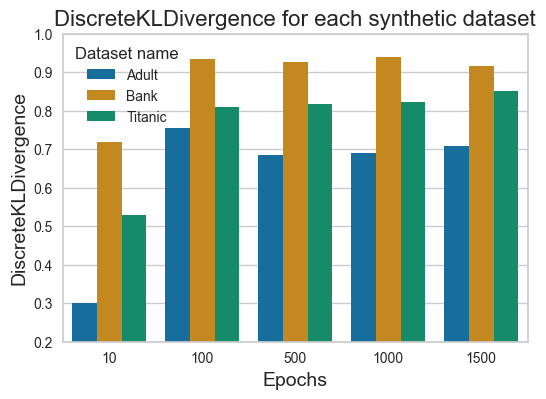

In [33]:
x_axis = 'Epochs'
y_axis = 'DiscreteKLDivergence'

# o_ids defined in pMSE 
data = grouped_result.copy()


plt.figure(figsize=fig_pf_epochs_size)

# Iterate through unique original datasets
sns.barplot(x=x_axis, y=y_axis, data=data, hue='Original id', hue_order=cat_o_ids)



# Define ticks
unique_epochs = data['Epochs'].unique().astype(int)

# Add labels and title
plt.xlabel(x_axis, fontsize=fig_pf_e_axel_label_size)
plt.ylabel(y_axis, fontsize=fig_pf_e_axel_label_size)
plt.title(f"{y_axis} for each synthetic dataset", fontsize=fig_pf_epochs_title_size)

plt.ylim(0.2,1)

# Add legend
plt.legend(title='Dataset name',loc='upper left')


# Display the plot
plt.savefig(f"{figures_fp}{y_axis}_vs_{x_axis}.png", bbox_inches='tight', dpi=fig_pf_epochs_dpi)
plt.show()

### vs Performance of all datasets and models

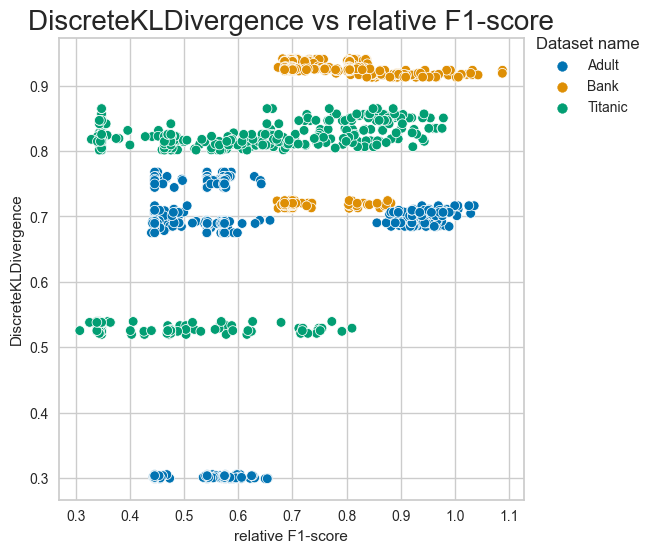

In [34]:
x_axis = 'F1_macro_ratio'
y_axis = 'DiscreteKLDivergence'

# Create a single figure
plt.figure(figsize=(6,6))

# Plot data for all models and datasets on the same plot
sns.scatterplot(x=x_axis, y=y_axis, data=result, hue='Original id', hue_order=cat_o_ids)
# Add labels and title
plt.xlabel('relative F1-score')
plt.ylabel(y_axis)
#{y_axis} vs relative F1-score for all datasets and models
plt.title(f"{y_axis} vs relative F1-score", fontsize=20)

# Add legend
plt.legend(title='Dataset name', bbox_to_anchor=(1, 1.03), loc='upper left')


plt.savefig(f"{figures_fp}{y_axis}_vs_overall_{x_axis}.png", bbox_inches='tight', dpi=300)
plt.show()


### DiscreteKLDivergence vs Performance of all dataset for each model

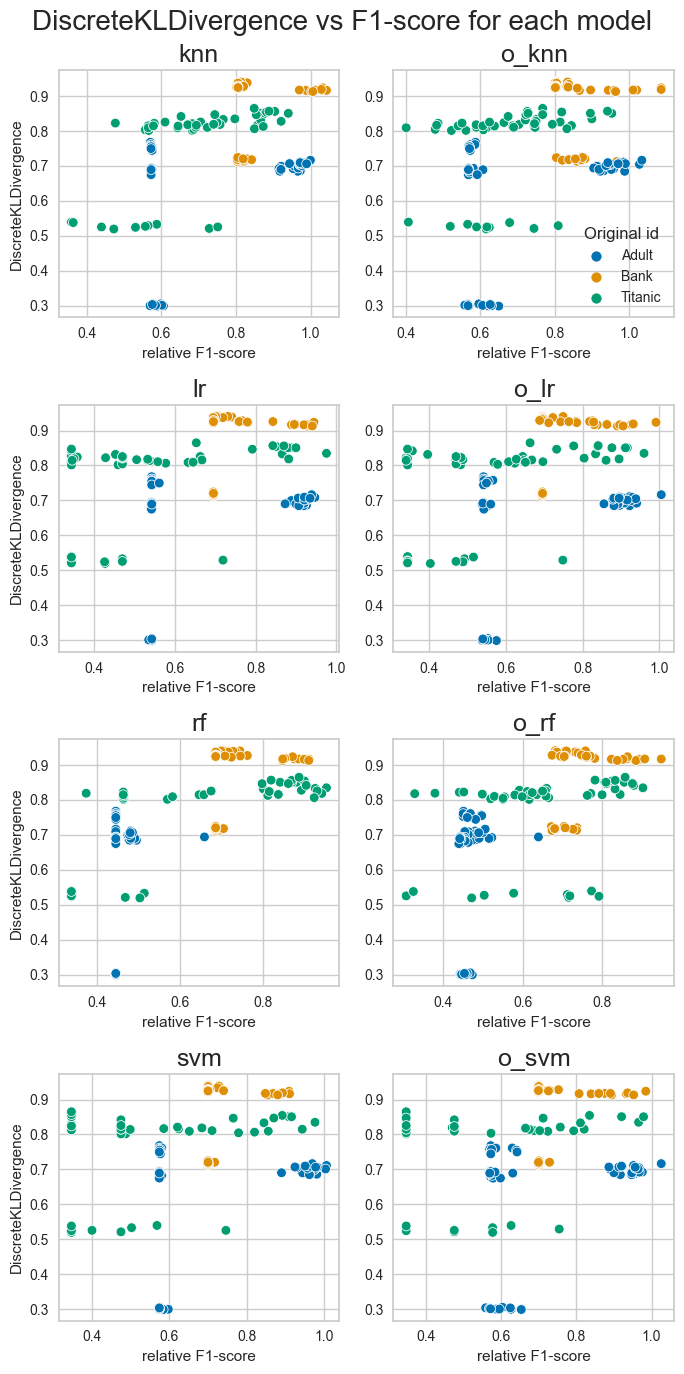

In [35]:
x_axis = 'F1_macro_ratio'
y_axis = 'DiscreteKLDivergence'

data = result.copy()
# Set up the 4x2 grid plot
fig, axes = plt.subplots(4, 2, figsize=(7, 14))
fig.suptitle(f"{y_axis} vs F1-score for each model", fontsize=20)
axes = axes.flatten()
ax_num = 0 


# Iterate over each model and each subplot axis
for ax, model in zip(axes, models):
    filtered_data = data[data['model']==model]
    sns.scatterplot(x=x_axis, y=y_axis, data=filtered_data, ax=ax, hue='Original id', hue_order=cat_o_ids)
    ax.set_title(model, fontsize=18)

    if ax_num != 1:
        ax.legend().remove()
    if ax_num % 2 == 0:
        ax.set_ylabel(y_axis) 
    else:
        ax.set_ylabel('')
    ax.set_xlabel("relative F1-score")

    ax_num += 1

# Adjust layout
plt.tight_layout()
plt.savefig(f"{figures_fp}{y_axis}_vs_{x_axis}.png", bbox_inches='tight', dpi=300)
plt.show()

### Spearman rank correlation coeficient test

In [36]:
pf_str = 'DiscreteKLDivergence'
display(specific_hyptest[pf_str])

Metric  correlation  p-value         c.interval
model                                          
knn          0.3631   0.0000    [0.1664, 0.532]
o_knn        0.2747   0.0009   [0.0693, 0.4577]
lr           0.2551   0.0021   [0.0484, 0.4409]
o_lr         0.2715   0.0010     [0.066, 0.455]
rf           0.7172   0.0000   [0.5977, 0.8056]
o_rf         0.6438   0.0000   [0.5021, 0.7518]
svm          0.1672   0.0469  [-0.0437, 0.3638]
o_svm        0.1502   0.0747   [-0.061, 0.3486]

## KSComplement

### vs Epochs for each dataset

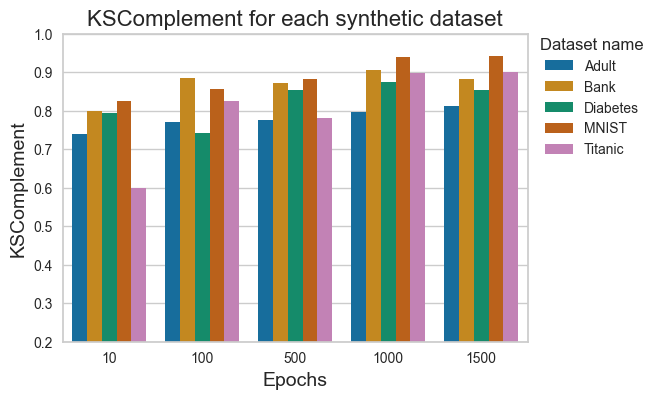

In [37]:
x_axis = 'Epochs'
y_axis = 'KSComplement'

# o_ids defined in pMSE 
data = grouped_result.copy()


plt.figure(figsize=fig_pf_epochs_size)

# Iterate through unique original datasets
sns.barplot(x=x_axis, y=y_axis, data=data, hue='Original id', hue_order=o_ids)

# Add labels and title
plt.xlabel(x_axis, fontsize=fig_pf_e_axel_label_size)
plt.ylabel(y_axis, fontsize=fig_pf_e_axel_label_size)
plt.title(f"{y_axis} for each synthetic dataset", fontsize=fig_pf_epochs_title_size)
plt.ylim(0.2,1)

# Add legend
plt.legend(title='Dataset name', loc='upper left', bbox_to_anchor=(1, 1.03))


# Display the plot
plt.savefig(f"{figures_fp}{x_axis}_vs_{y_axis}.png", bbox_inches='tight', dpi=fig_pf_epochs_dpi)
plt.show()

### vs Performance of all datasets and models

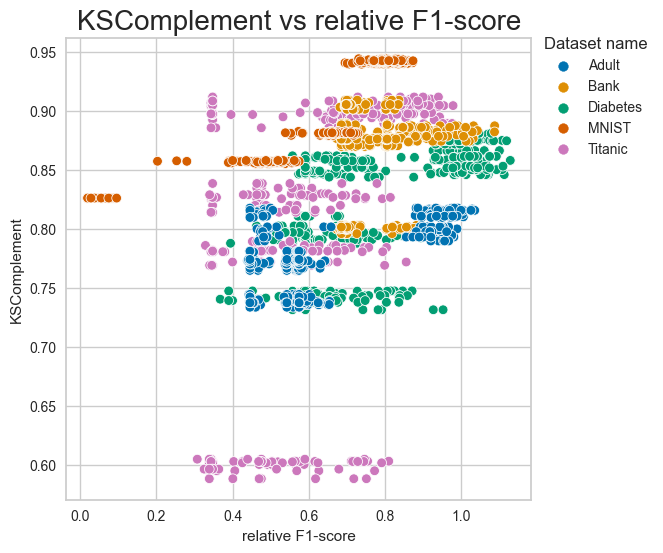

In [38]:
x_axis = 'F1_macro_ratio'
y_axis = 'KSComplement'

# Create a single figure
plt.figure(figsize=(6,6))

# Plot data for all models and datasets on the same plot
sns.scatterplot(x=x_axis, y=y_axis, data=result, hue='Original id', hue_order=o_ids)
# Add labels and title
plt.xlabel('relative F1-score')
plt.ylabel(y_axis)
plt.title(f"{y_axis} vs relative F1-score", fontsize=20)


# Add legend
plt.legend(title='Dataset name', bbox_to_anchor=(1, 1.03), loc='upper left')

plt.savefig(f"{figures_fp}{y_axis}_vs_overall_{x_axis}.png", bbox_inches='tight', dpi=300)
plt.show()


### vs Performance of all dataset for each model

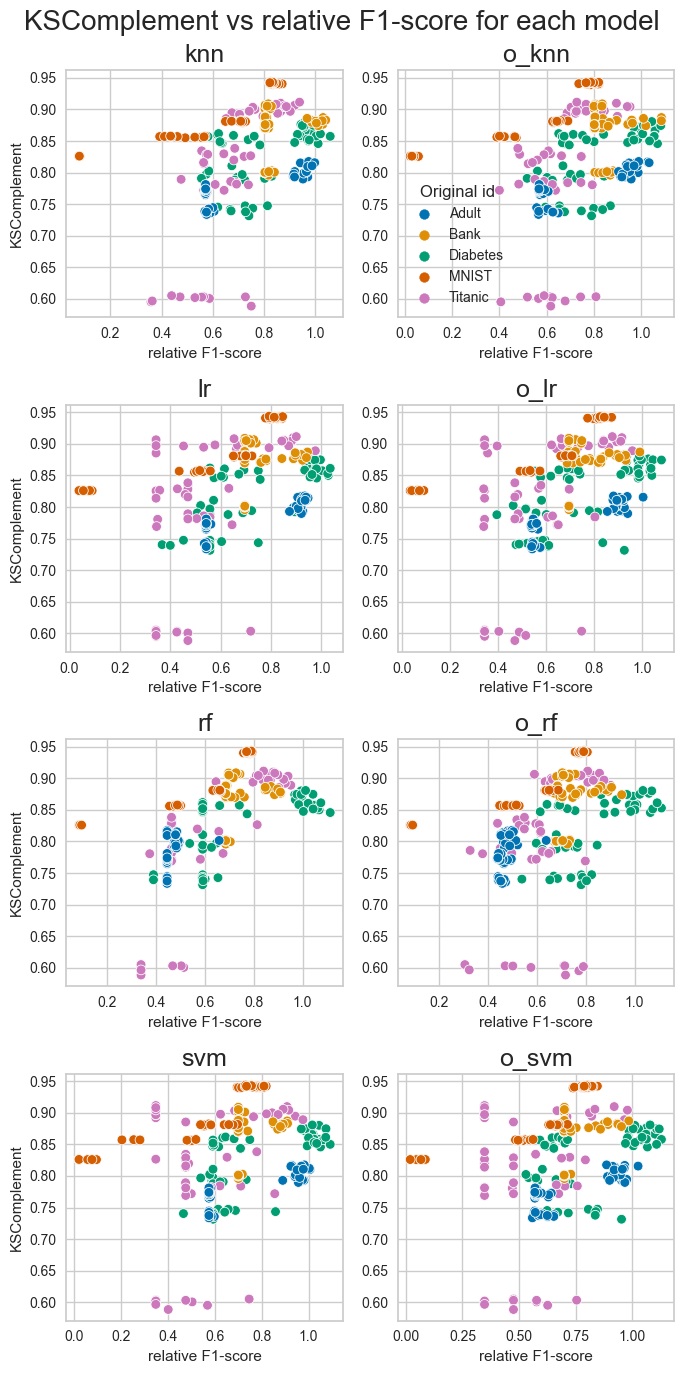

In [39]:
x_axis = 'F1_macro_ratio'
y_axis = 'KSComplement'

data = result.copy()
# Set up the 4x2 grid plot
fig, axes = plt.subplots(4, 2, figsize=(7,14))
fig.suptitle(f"{y_axis} vs relative F1-score for each model", fontsize=20)
axes = axes.flatten()
ax_num = 0 


# Iterate over each model and each subplot axis
for ax, model in zip(axes, models):
    filtered_data = data[data['model']==model]
    sns.scatterplot(x=x_axis, y=y_axis, data=filtered_data, ax=ax, hue='Original id', hue_order=o_ids)
    ax.set_title(model, fontsize=18)

    if ax_num != 1:
        ax.legend().remove()
    if ax_num % 2 == 0:
        ax.set_ylabel(y_axis) 
        ax.legend().remove()
    else:
        ax.set_ylabel('')
    ax.set_xlabel("relative F1-score")

    ax_num += 1

# Adjust layout
plt.tight_layout()
plt.savefig(f"{figures_fp}{y_axis}_vs_{x_axis}.png", bbox_inches='tight', dpi=300)
plt.show()

### Spearman rank correlation coeficient test

In [40]:
pf_str = 'KSComplement'
specific_hyptest[pf_str]

Metric  correlation  p-value        c.interval
model                                         
knn          0.4937   0.0000  [0.3601, 0.6074]
o_knn        0.3687   0.0000  [0.2193, 0.5011]
lr           0.4525   0.0000   [0.313, 0.5728]
o_lr         0.4344   0.0000  [0.2926, 0.5575]
rf           0.7296   0.0000  [0.6434, 0.7975]
o_rf         0.5366   0.0000   [0.4099, 0.643]
svm          0.3413   0.0000  [0.1894, 0.4773]
o_svm        0.2815   0.0000  [0.1248, 0.4246]

## CSTest

### vs Epochs for each dataset

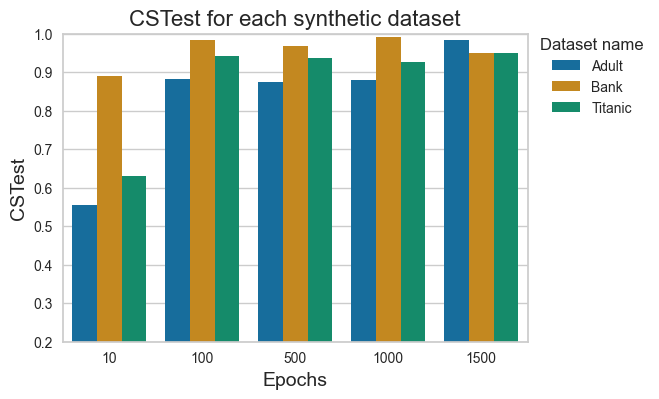

In [41]:
x_axis = 'Epochs'
y_axis = 'CSTest'

# o_ids defined in pMSE 
data = grouped_result.copy()


plt.figure(figsize=fig_pf_epochs_size)

# Iterate through unique original datasets
sns.barplot(x=x_axis, y=y_axis, data=data, hue='Original id', hue_order=cat_o_ids)

# Add labels and title
plt.xlabel(x_axis, fontsize=fig_pf_e_axel_label_size)
plt.ylabel(y_axis, fontsize=fig_pf_e_axel_label_size)
plt.title(f"{y_axis} for each synthetic dataset", fontsize=fig_pf_epochs_title_size)

# Add legend
plt.legend(title='Dataset name', loc='upper left', bbox_to_anchor=(1, 1.03))

plt.ylim(0.2,1)


# Display the plot
plt.savefig(f"{figures_fp}{x_axis}_vs_{y_axis}.png", bbox_inches='tight', dpi=fig_pf_epochs_dpi)
plt.show()

### vs Performance of all datasets and models

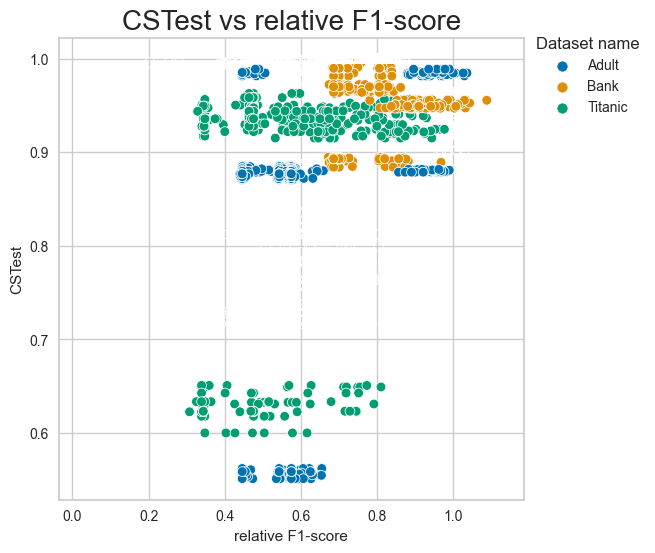

In [42]:
x_axis = 'F1_macro_ratio'
y_axis = 'CSTest'

# Create a single figure
plt.figure(figsize=(6,6))

# Plot data for all models and datasets on the same plot
sns.scatterplot(x=x_axis, y=y_axis, data=result, hue='Original id', hue_order=cat_o_ids)
# Add labels and title
plt.xlabel('relative F1-score')
plt.ylabel(y_axis)
plt.title(f"{y_axis} vs relative F1-score", fontsize=20)


# Add legend
plt.legend(title='Dataset name', bbox_to_anchor=(1, 1.03), loc='upper left')

plt.savefig(f"{figures_fp}{y_axis}_vs_overall_{x_axis}.png", bbox_inches='tight', dpi=300)
plt.show()


### vs Performance of all dataset for each model

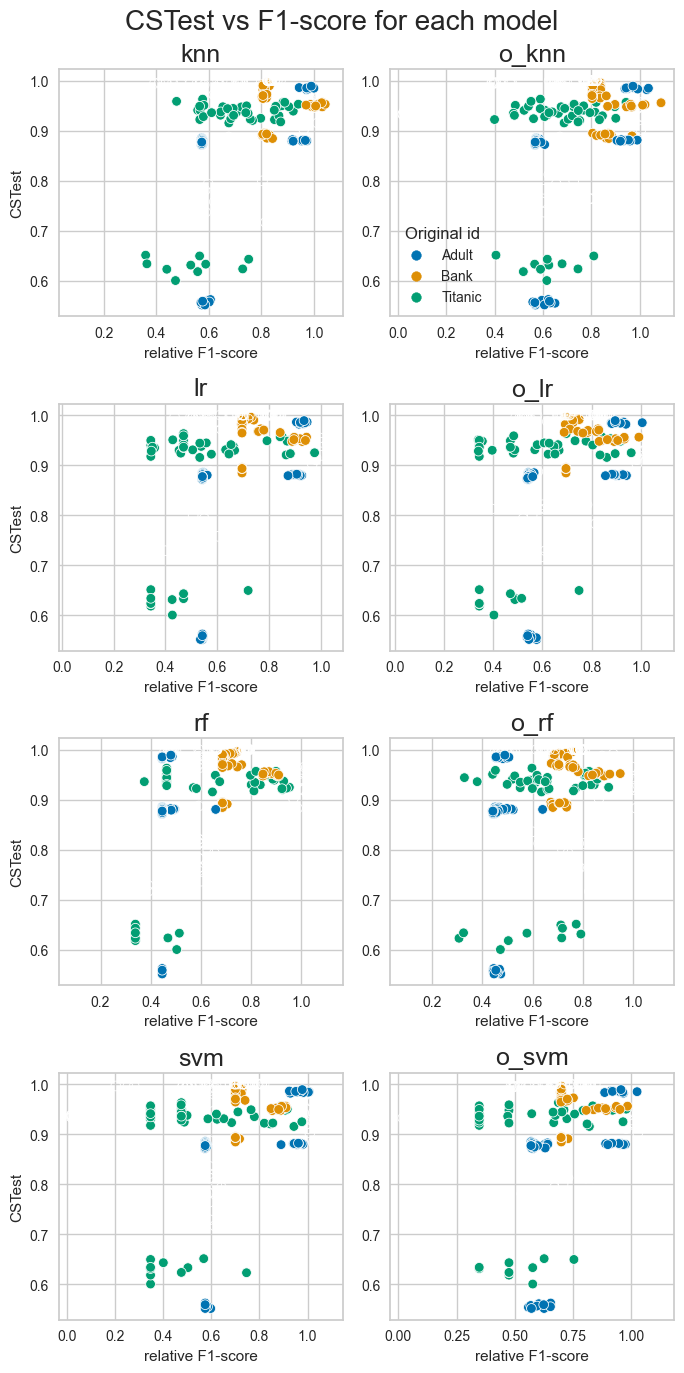

In [43]:
x_axis = 'F1_macro_ratio'
y_axis = 'CSTest'

data = result.copy()
# Set up the 4x2 grid plot
fig, axes = plt.subplots(4, 2, figsize=(7, 14))
fig.suptitle(f"{y_axis} vs F1-score for each model", fontsize=20)
axes = axes.flatten()
ax_num = 0 


# Iterate over each model and each subplot axis
for ax, model in zip(axes, models):
    filtered_data = data[data['model']==model]
    sns.scatterplot(x=x_axis, y=y_axis, data=filtered_data, ax=ax, hue='Original id', hue_order=cat_o_ids)
    ax.set_title(model, fontsize=18)

    if ax_num != 1:
        ax.legend().remove()
    if ax_num % 2 == 0:
        ax.set_ylabel(y_axis) 
    else:
        ax.set_ylabel('')
    ax.set_xlabel("relative F1-score")

    ax_num += 1

# Adjust layout
plt.tight_layout()
plt.savefig(f"{figures_fp}{y_axis}_vs_{x_axis}.png", bbox_inches='tight', dpi=300)
plt.show()

### Spearman rank correlation coeficient test

In [44]:
pf_str = 'CSTest'
specific_hyptest[pf_str]

Metric  correlation  p-value        c.interval
model                                         
knn          0.5350   0.0000  [0.3667, 0.6693]
o_knn        0.4691   0.0000   [0.288, 0.6177]
lr           0.4462   0.0000  [0.2613, 0.5995]
o_lr         0.4514   0.0000  [0.2673, 0.6036]
rf           0.5413   0.0000  [0.3744, 0.6742]
o_rf         0.4700   0.0000  [0.2892, 0.6185]
svm          0.3742   0.0000  [0.1789, 0.5412]
o_svm        0.3620   0.0000  [0.1652, 0.5311]

## CrCl

### vs Epochs for each dataset

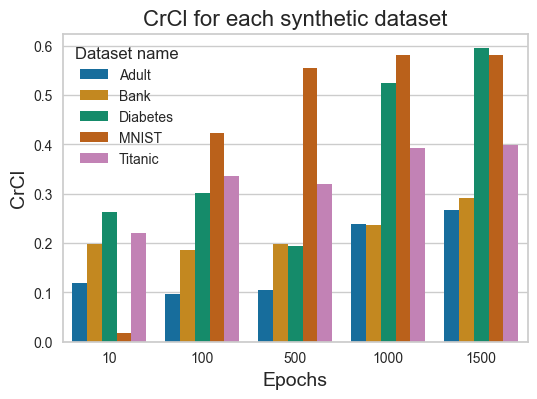

In [45]:
x_axis = 'Epochs'
y_axis = 'CrCl'

# o_ids defined in pMSE
data = grouped_result.copy()


plt.figure(figsize=fig_pf_epochs_size)

# Iterate through unique original datasets
sns.barplot(x=x_axis, y=y_axis, data=data, hue='Original id', hue_order=o_ids)

# Add labels and title
plt.xlabel(x_axis, fontsize=fig_pf_e_axel_label_size)
plt.ylabel(y_axis, fontsize=fig_pf_e_axel_label_size)
plt.title(f"{y_axis} for each synthetic dataset", fontsize=fig_pf_epochs_title_size)

# Add legend
plt.legend(title='Dataset name', loc='upper left')


# Display the plot
plt.savefig(f"{figures_fp}{x_axis}_vs_{y_axis}.png", bbox_inches='tight', dpi=fig_pf_epochs_dpi)
plt.show()

### vs Performance of all datasets and models

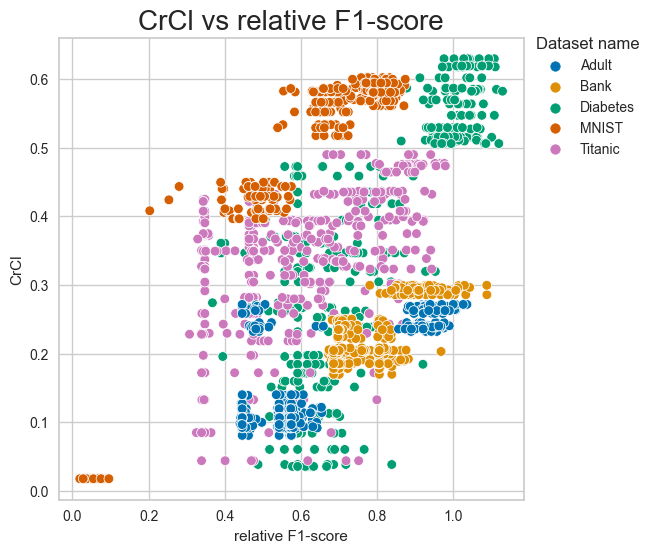

In [46]:
x_axis = 'F1_macro_ratio'
y_axis = 'CrCl'

# Create a single figure
plt.figure(figsize=(6,6))

# Plot data for all models and datasets on the same plot
sns.scatterplot(x=x_axis, y=y_axis, data=result, hue='Original id', hue_order=o_ids)
# Add labels and title
plt.xlabel('relative F1-score')
plt.ylabel(y_axis)
plt.title(f"{y_axis} vs relative F1-score", fontsize=20)


# Add legend
plt.legend(title='Dataset name', bbox_to_anchor=(1, 1.03), loc='upper left')

plt.savefig(f"{figures_fp}{y_axis}_vs_overall_{x_axis}.png", bbox_inches='tight', dpi=300)
plt.show()


### vs Performance on all dataset for each model

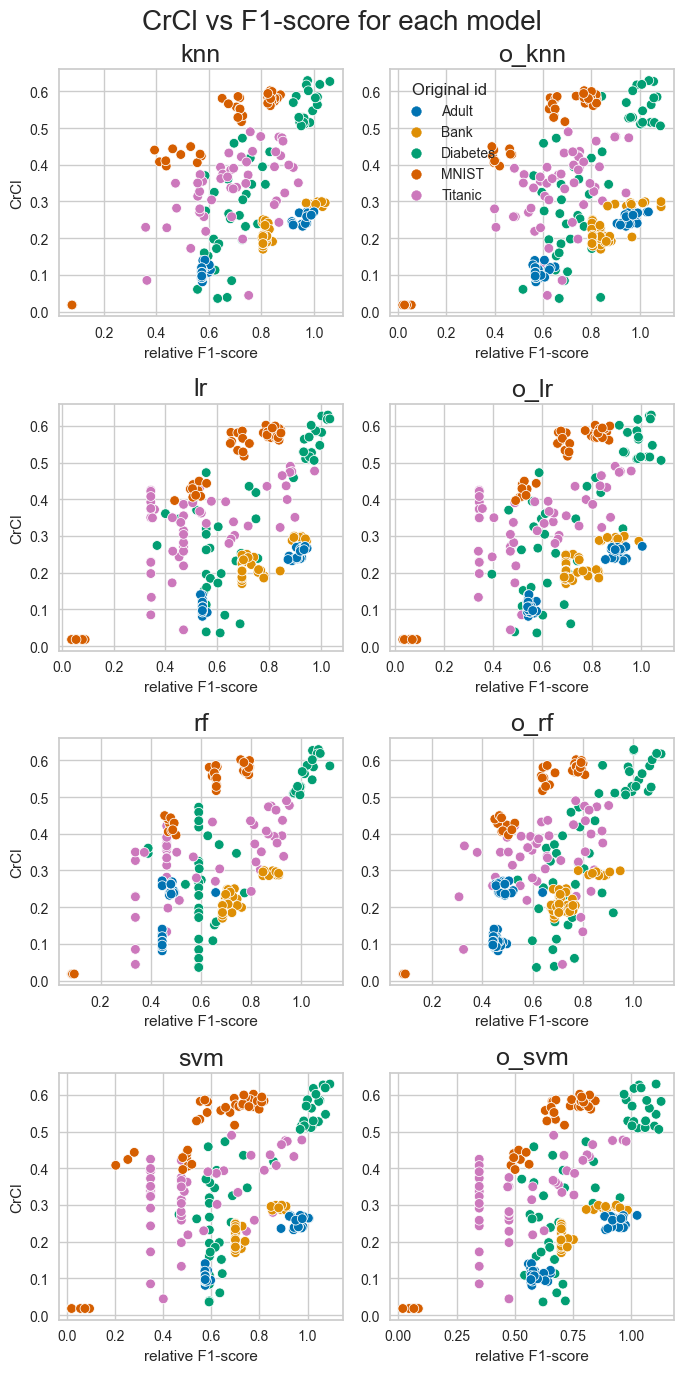

In [47]:
x_axis = 'F1_macro_ratio'
y_axis = 'CrCl'

data = result.copy()
# Set up the 4x2 grid plot
fig, axes = plt.subplots(4, 2, figsize=(7,14))
fig.suptitle(f"{y_axis} vs F1-score for each model", fontsize=20)
axes = axes.flatten()
ax_num = 0 


# Iterate over each model and each subplot axis
for ax, model in zip(axes, models):
    filtered_data = data[data['model']==model]
    sns.scatterplot(x=x_axis, y=y_axis, data=filtered_data, ax=ax, hue='Original id', hue_order=o_ids)
    ax.set_title(model, fontsize=18)

    if ax_num != 1:
        ax.legend().remove()
    if ax_num % 2 == 0:
        ax.set_ylabel(y_axis) 
    else:
        ax.set_ylabel('')
    ax.set_xlabel("relative F1-score")

    ax_num += 1

# Adjust layout
plt.tight_layout()
plt.savefig(f"{figures_fp}{y_axis}_vs_{x_axis}.png", bbox_inches='tight', dpi=300)
plt.show()

### Spearman rank correlation coeficient test

In [48]:
pf_str = 'CrCl'
specific_hyptest[pf_str]

Metric  correlation  p-value        c.interval
model                                         
knn          0.4720   0.0000  [0.3353, 0.5893]
o_knn        0.3394   0.0000  [0.1873, 0.4756]
lr           0.4590   0.0000  [0.3204, 0.5783]
o_lr         0.4878   0.0000  [0.3534, 0.6025]
rf           0.6086   0.0000  [0.4951, 0.7017]
o_rf         0.5559   0.0000  [0.4325, 0.6589]
svm          0.3969   0.0000  [0.2506, 0.5255]
o_svm        0.4392   0.0000   [0.298, 0.5616]

## Misc PF plots

## Time plots

In [49]:
display(f"Number of days to compute all PF measures: {round(result[pf_metric_times].sum().sum()/(24*3600), 1)}")
display('Computation hours for each PF measure: ')
display(round(result[pf_metric_times].sum()/3600, 2))

'Number of days to compute all PF measures: 21.6'

'Computation hours for each PF measure: '

BNLogLikelihood_time           0.1000
Cluster_G_1_time             379.1500
ContinousKLDivergence_time   131.2800
CrCl_time                      2.2100
CSTest_time                    0.0100
DiscreteKLDivergence_time      0.0400
GMLogLikelihood_time           5.6200
KSComplement_time              0.1700
pMSE_time                      0.3300
dtype: float64